<a href="https://colab.research.google.com/github/elsaimo/4106_Final_project/blob/main/SelenaNahraFinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 10/100, Training Loss: 14.7078, Validation Loss: 15.4965
Train RMSE: 3.8351, Val RMSE: 3.9366
Epoch 20/100, Training Loss: 4.7939, Validation Loss: 5.4896
Train RMSE: 2.1895, Val RMSE: 2.3430
Epoch 30/100, Training Loss: 3.1566, Validation Loss: 3.4328
Train RMSE: 1.7767, Val RMSE: 1.8528
Epoch 40/100, Training Loss: 2.4784, Validation Loss: 2.5686
Train RMSE: 1.5743, Val RMSE: 1.6027
Epoch 50/100, Training Loss: 2.0169, Validation Loss: 2.0785
Train RMSE: 1.4202, Val RMSE: 1.4417
Epoch 60/100, Training Loss: 1.7164, Validation Loss: 1.7942
Train RMSE: 1.3101, Val RMSE: 1.3395
Epoch 70/100, Training Loss: 1.4780, Validation Loss: 1.5739
Train RMSE: 1.2157, Val RMSE: 1.2546
Epoch 80/100, Training Loss: 1.2751, Validation Loss: 1.3870
Train RMSE: 1.1292, Val RMSE: 1.1777
Epoch 90/100, Training Loss: 0.9205, Validation Loss: 1.0712
Train RMSE: 0.9594, Val RMSE: 1.0350
Epoch 100/100, Training Loss: 0.7636, Validation Loss: 0.9055
Train RMSE: 0.8739, Val RMSE: 0.9516
Epoch 10/100, Tra

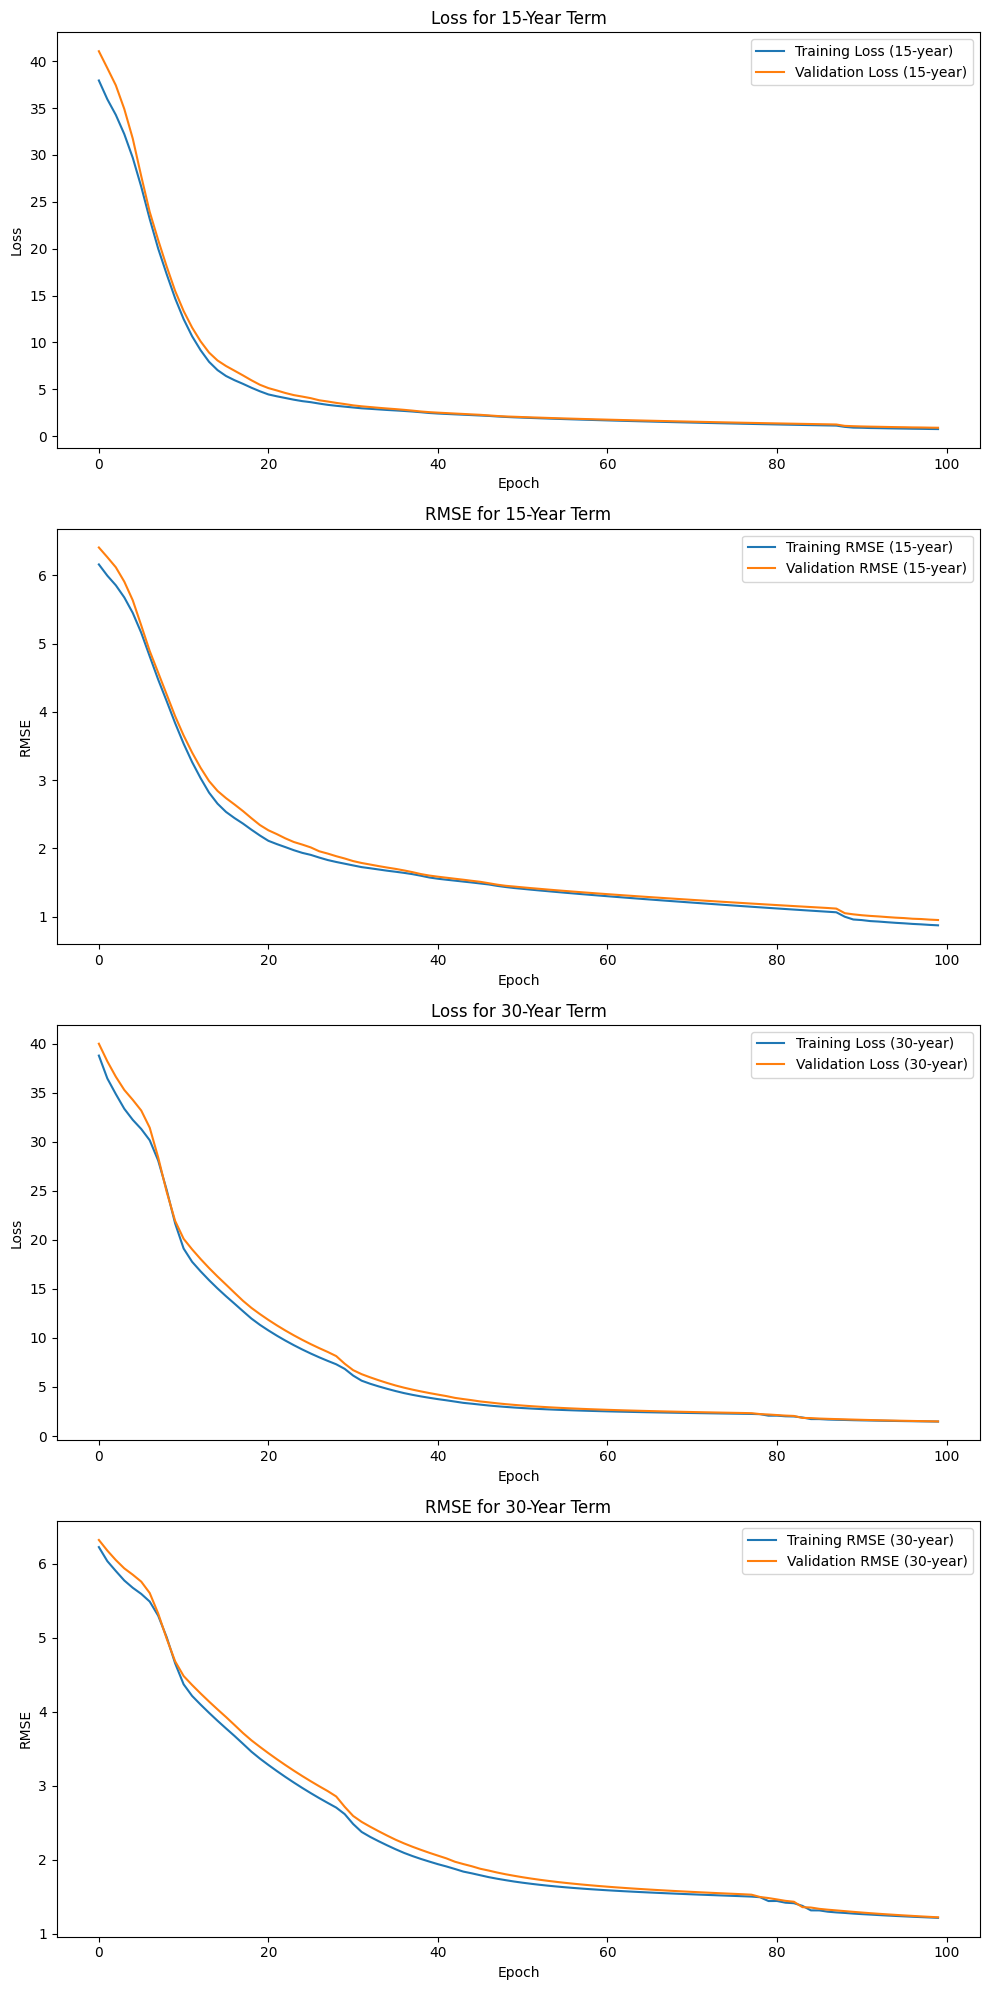

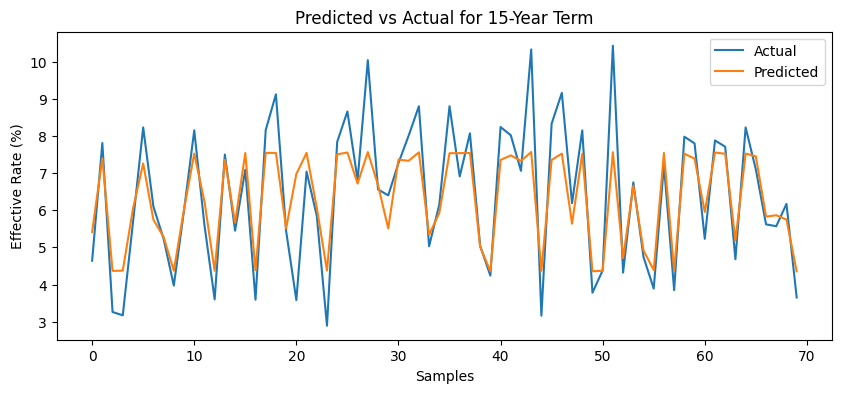

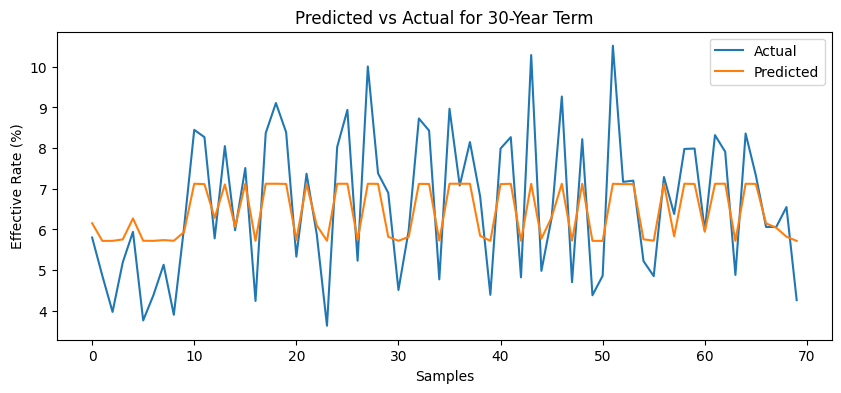

In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import math
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Load the dataset
def load_data(path):
    df = pd.read_csv(path)
    df = df.drop(index=0)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(inplace=True)  # Handling NaNs by removing; you might choose to fill them instead
    df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(Day=1))
    df.sort_values('Date', inplace=True)
    df.drop(['Year', 'Month'], axis=1, inplace=True)
    return df

# Define RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SimpleRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        return self.fc(out)

# Create sequences for modeling
def create_sequences(data, sequence_length):
    X = []
    y = []
    feature_data = data.drop(['Effective Rate (%)', 'Date'], axis=1)
    target_data = data['Effective Rate (%)']
    for i in range(len(data) - sequence_length):
        seq = feature_data.iloc[i:(i + sequence_length)].values
        label = target_data.iloc[i + sequence_length]
        X.append(seq)
        y.append(label)
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# Prepare data loaders
def prepare_data(X, y, batch_size=64, test_size=0.2):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

# Compute RMSE
def compute_rmse(predictions, targets):
    return math.sqrt(((predictions - targets) ** 2).mean())

def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, train_loss_list, val_loss_list, train_rmse_list, val_rmse_list):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_predictions, train_targets_list = [], []
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            train_predictions.extend(outputs.detach().squeeze().tolist())
            train_targets_list.extend(targets.tolist())

        train_loss /= len(train_loader.dataset)
        train_loss_list.append(train_loss)
        train_rmse = compute_rmse(np.array(train_predictions), np.array(train_targets_list))
        train_rmse_list.append(train_rmse)

        model.eval()
        val_loss = 0.0
        val_predictions, val_targets_list = [], []
        for val_inputs, val_targets in val_loader:
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs.squeeze(), val_targets).item() * val_inputs.size(0)
            val_predictions.extend(val_outputs.detach().squeeze().tolist())
            val_targets_list.extend(val_targets.tolist())

        val_loss /= len(val_loader.dataset)
        val_loss_list.append(val_loss)
        val_rmse = compute_rmse(np.array(val_predictions), np.array(val_targets_list))
        val_rmse_list.append(val_rmse)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
            print(f'Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}')

    return model

# Main execution
if __name__ == "__main__":
    dataset_path = 'Cleaned_FHFAInterestRates.csv'
    df = load_data(dataset_path)
    df_15 = df[df['Term to Maturity'] == 15].copy()
    df_30 = df[df['Term to Maturity'] == 30].copy()

    X_15, y_15 = create_sequences(df_15, 3)
    X_30, y_30 = create_sequences(df_30, 3)

    model_15 = SimpleRNN(7, 50, 1, 1)
    model_30 = SimpleRNN(7, 50, 1, 1)

    train_loader_15, val_loader_15 = prepare_data(X_15, y_15)
    train_loader_30, val_loader_30 = prepare_data(X_30, y_30)

    criterion = nn.MSELoss()
    optimizer_15 = optim.Adam(model_15.parameters(), lr=0.001)
    optimizer_30 = optim.Adam(model_30.parameters(), lr=0.001)

    train_loss_list_15 = []
    val_loss_list_15 = []
    train_rmse_list_15 = []
    val_rmse_list_15 = []

    train_loss_list_30 = []
    val_loss_list_30 = []
    train_rmse_list_30 = []
    val_rmse_list_30 = []

    trained_model_15 = train_model(model_15, train_loader_15, val_loader_15, optimizer_15, criterion, 100, train_loss_list_15, val_loss_list_15, train_rmse_list_15, val_rmse_list_15)
    trained_model_30 = train_model(model_30, train_loader_30, val_loader_30, optimizer_30, criterion, 100, train_loss_list_30, val_loss_list_30, train_rmse_list_30, val_rmse_list_30)

    # Plotting the results
    fig, axes = plt.subplots(4, 1, figsize=(10, 20))

    axes[0].plot(train_loss_list_15, label='Training Loss (15-year)')
    axes[0].plot(val_loss_list_15, label='Validation Loss (15-year)')
    axes[0].set_title('Loss for 15-Year Term')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(train_rmse_list_15, label='Training RMSE (15-year)')
    axes[1].plot(val_rmse_list_15, label='Validation RMSE (15-year)')
    axes[1].set_title('RMSE for 15-Year Term')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('RMSE')
    axes[1].legend()

    axes[2].plot(train_loss_list_30, label='Training Loss (30-year)')
    axes[2].plot(val_loss_list_30, label='Validation Loss (30-year)')
    axes[2].set_title('Loss for 30-Year Term')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')
    axes[2].legend()

    axes[3].plot(train_rmse_list_30, label='Training RMSE (30-year)')
    axes[3].plot(val_rmse_list_30, label='Validation RMSE (30-year)')
    axes[3].set_title('RMSE for 30-Year Term')
    axes[3].set_xlabel('Epoch')
    axes[3].set_ylabel('RMSE')
    axes[3].legend()

    plt.tight_layout()
    plt.show()

def plot_predictions(model, loader, title):
  model.eval()
  predictions, actuals = [], []
  with torch.no_grad():
      for inputs, targets in loader:
          outputs = model(inputs)
          predictions.extend(outputs.detach().squeeze().tolist())
          actuals.extend(targets.tolist())
  plt.figure(figsize=(10, 4))
  plt.plot(actuals, label='Actual')
  plt.plot(predictions, label='Predicted')
  plt.title(f'Predicted vs Actual for {title}')
  plt.xlabel('Samples')
  plt.ylabel('Effective Rate (%)')
  plt.legend()
  plt.show()

# Plot predicted vs actual for 15-year term
plot_predictions(trained_model_15, val_loader_15, '15-Year Term')

# Plot predicted vs actual for 30-year term
plot_predictions(trained_model_30, val_loader_30, '30-Year Term')




Batch Size 32

Epoch 10/100, Training Loss: 6.7178, Validation Loss: 7.1612
Train RMSE: 2.5919, Val RMSE: 2.6761
Epoch 20/100, Training Loss: 3.2233, Validation Loss: 3.4845
Train RMSE: 1.7954, Val RMSE: 1.8667
Epoch 30/100, Training Loss: 2.6299, Validation Loss: 2.6973
Train RMSE: 1.6217, Val RMSE: 1.6423
Epoch 40/100, Training Loss: 1.6587, Validation Loss: 1.6824
Train RMSE: 1.2879, Val RMSE: 1.2971
Epoch 50/100, Training Loss: 1.0769, Validation Loss: 1.1551
Train RMSE: 1.0377, Val RMSE: 1.0748
Epoch 60/100, Training Loss: 0.8471, Validation Loss: 0.9564
Train RMSE: 0.9204, Val RMSE: 0.9780
Epoch 70/100, Training Loss: 0.6520, Validation Loss: 0.7836
Train RMSE: 0.8074, Val RMSE: 0.8852
Epoch 80/100, Training Loss: 0.4518, Validation Loss: 0.6003
Train RMSE: 0.6722, Val RMSE: 0.7748
Epoch 90/100, Training Loss: 0.3422, Validation Loss: 0.4620
Train RMSE: 0.5849, Val RMSE: 0.6797
Epoch 100/100, Training Loss: 0.2850, Validation Loss: 0.3884
Train RMSE: 0.5339, Val RMSE: 0.6232
Epoch 10/100, Train

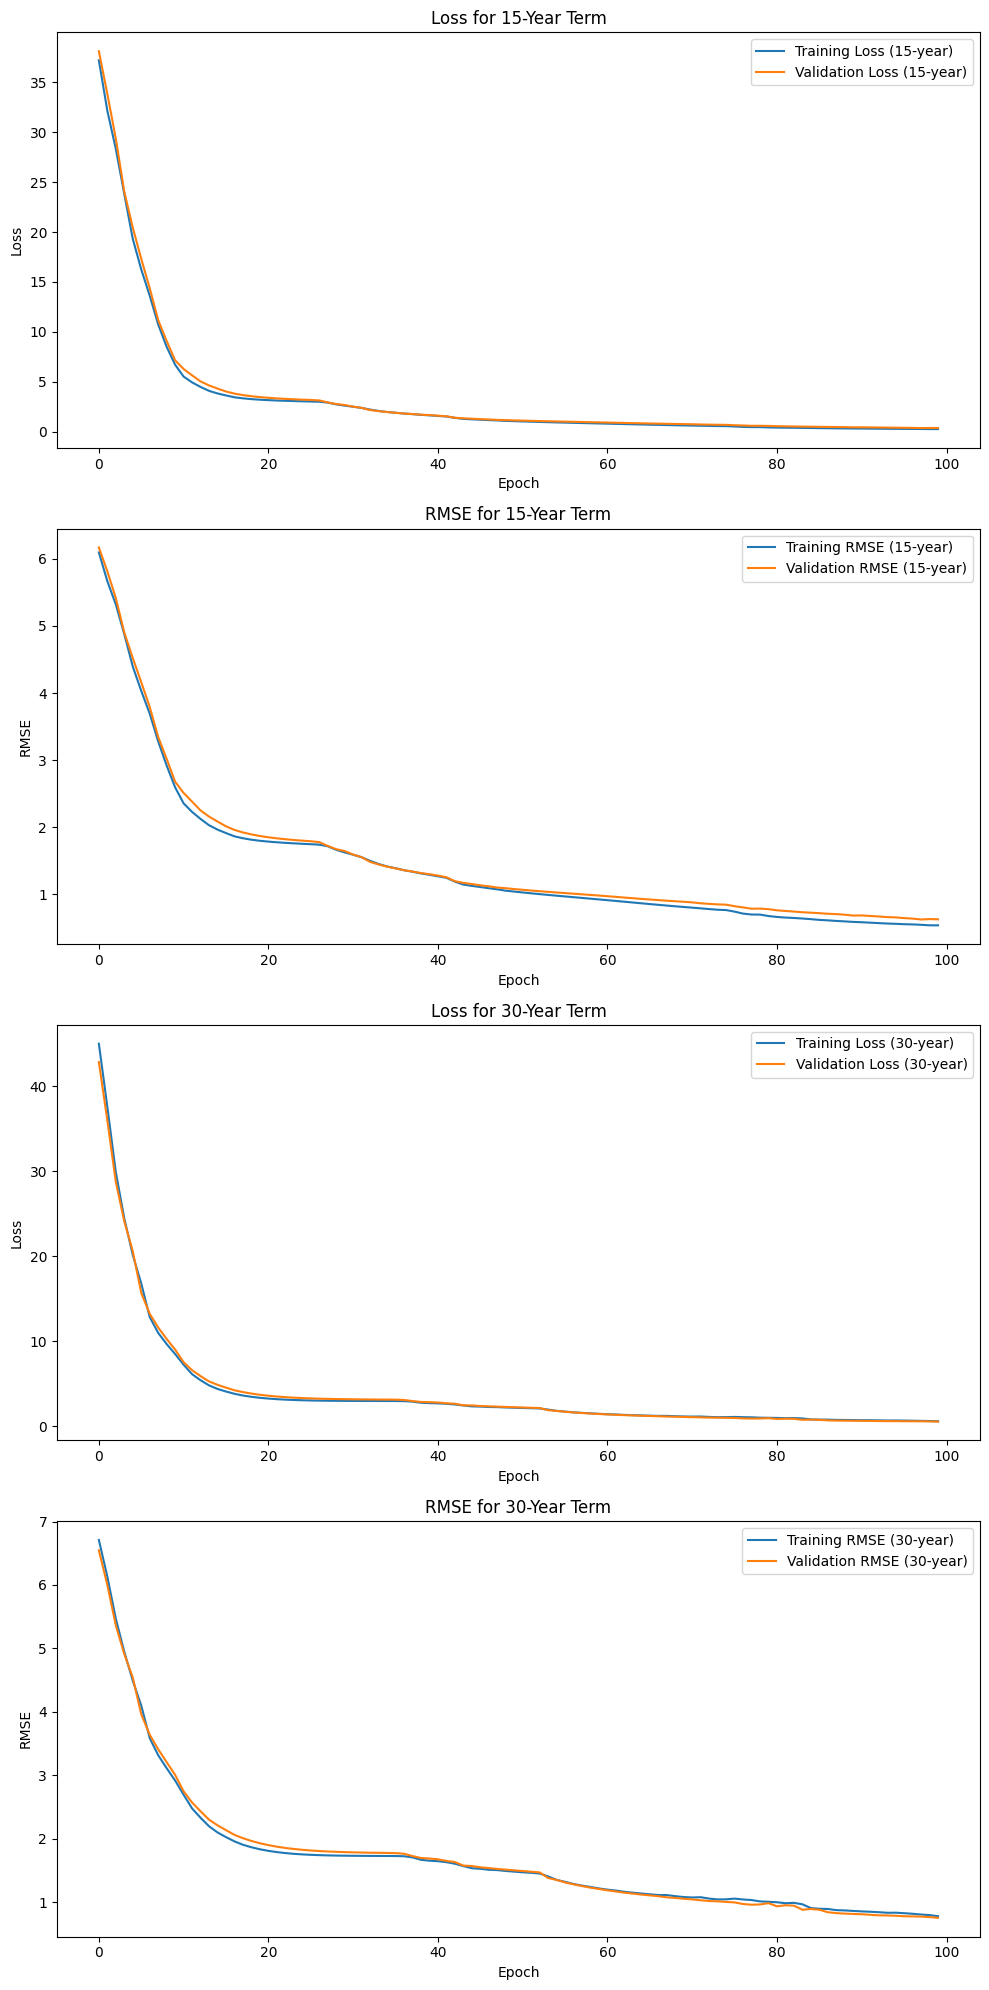

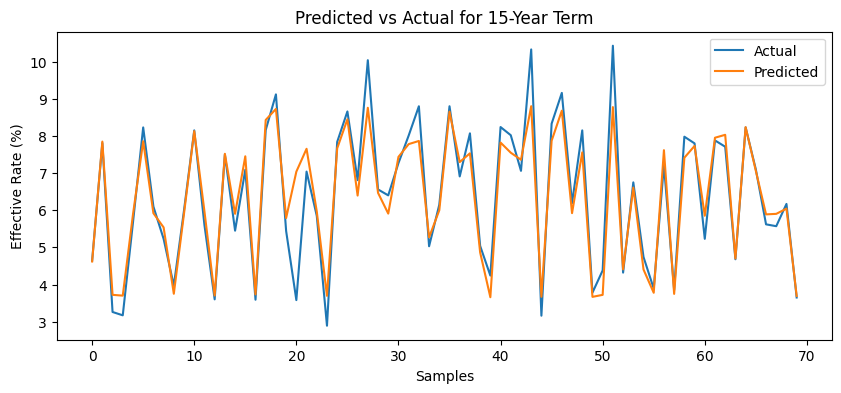

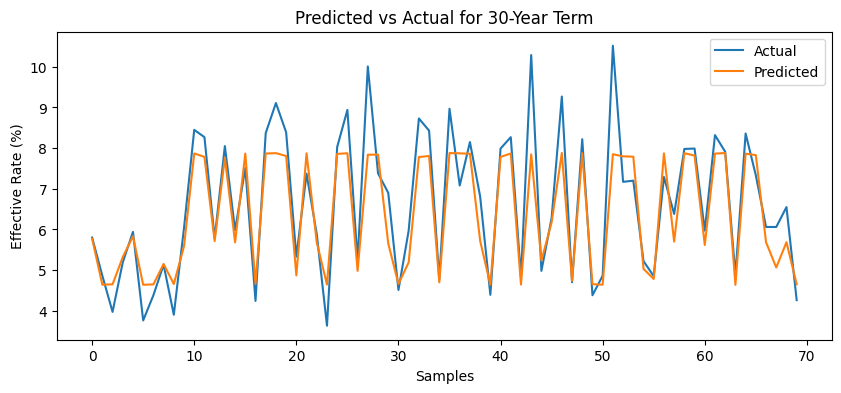

In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import math
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Load the dataset
def load_data(path):
    df = pd.read_csv(path)
    df = df.drop(index=0)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(inplace=True)  # Handling NaNs by removing; you might choose to fill them instead
    df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(Day=1))
    df.sort_values('Date', inplace=True)
    df.drop(['Year', 'Month'], axis=1, inplace=True)
    return df

# Define RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SimpleRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        return self.fc(out)

# Create sequences for modeling
def create_sequences(data, sequence_length):
    X = []
    y = []
    feature_data = data.drop(['Effective Rate (%)', 'Date'], axis=1)
    target_data = data['Effective Rate (%)']
    for i in range(len(data) - sequence_length):
        seq = feature_data.iloc[i:(i + sequence_length)].values
        label = target_data.iloc[i + sequence_length]
        X.append(seq)
        y.append(label)
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# Prepare data loaders
def prepare_data(X, y, batch_size=32, test_size=0.2):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

# Compute RMSE
def compute_rmse(predictions, targets):
    return math.sqrt(((predictions - targets) ** 2).mean())

def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, train_loss_list, val_loss_list, train_rmse_list, val_rmse_list):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_predictions, train_targets_list = [], []
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            train_predictions.extend(outputs.detach().squeeze().tolist())
            train_targets_list.extend(targets.tolist())

        train_loss /= len(train_loader.dataset)
        train_loss_list.append(train_loss)
        train_rmse = compute_rmse(np.array(train_predictions), np.array(train_targets_list))
        train_rmse_list.append(train_rmse)

        model.eval()
        val_loss = 0.0
        val_predictions, val_targets_list = [], []
        for val_inputs, val_targets in val_loader:
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs.squeeze(), val_targets).item() * val_inputs.size(0)
            val_predictions.extend(val_outputs.detach().squeeze().tolist())
            val_targets_list.extend(val_targets.tolist())

        val_loss /= len(val_loader.dataset)
        val_loss_list.append(val_loss)
        val_rmse = compute_rmse(np.array(val_predictions), np.array(val_targets_list))
        val_rmse_list.append(val_rmse)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
            print(f'Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}')

    return model

# Main execution
if __name__ == "__main__":
    dataset_path = 'Cleaned_FHFAInterestRates.csv'
    df = load_data(dataset_path)
    df_15 = df[df['Term to Maturity'] == 15].copy()
    df_30 = df[df['Term to Maturity'] == 30].copy()

    X_15, y_15 = create_sequences(df_15, 3)
    X_30, y_30 = create_sequences(df_30, 3)

    model_15 = SimpleRNN(7, 50, 1, 1)
    model_30 = SimpleRNN(7, 50, 1, 1)

    train_loader_15, val_loader_15 = prepare_data(X_15, y_15)
    train_loader_30, val_loader_30 = prepare_data(X_30, y_30)

    criterion = nn.MSELoss()
    optimizer_15 = optim.Adam(model_15.parameters(), lr=0.001)
    optimizer_30 = optim.Adam(model_30.parameters(), lr=0.001)

    train_loss_list_15 = []
    val_loss_list_15 = []
    train_rmse_list_15 = []
    val_rmse_list_15 = []

    train_loss_list_30 = []
    val_loss_list_30 = []
    train_rmse_list_30 = []
    val_rmse_list_30 = []

    trained_model_15 = train_model(model_15, train_loader_15, val_loader_15, optimizer_15, criterion, 100, train_loss_list_15, val_loss_list_15, train_rmse_list_15, val_rmse_list_15)
    trained_model_30 = train_model(model_30, train_loader_30, val_loader_30, optimizer_30, criterion, 100, train_loss_list_30, val_loss_list_30, train_rmse_list_30, val_rmse_list_30)

    # Plotting the results
    fig, axes = plt.subplots(4, 1, figsize=(10, 20))

    axes[0].plot(train_loss_list_15, label='Training Loss (15-year)')
    axes[0].plot(val_loss_list_15, label='Validation Loss (15-year)')
    axes[0].set_title('Loss for 15-Year Term')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(train_rmse_list_15, label='Training RMSE (15-year)')
    axes[1].plot(val_rmse_list_15, label='Validation RMSE (15-year)')
    axes[1].set_title('RMSE for 15-Year Term')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('RMSE')
    axes[1].legend()

    axes[2].plot(train_loss_list_30, label='Training Loss (30-year)')
    axes[2].plot(val_loss_list_30, label='Validation Loss (30-year)')
    axes[2].set_title('Loss for 30-Year Term')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')
    axes[2].legend()

    axes[3].plot(train_rmse_list_30, label='Training RMSE (30-year)')
    axes[3].plot(val_rmse_list_30, label='Validation RMSE (30-year)')
    axes[3].set_title('RMSE for 30-Year Term')
    axes[3].set_xlabel('Epoch')
    axes[3].set_ylabel('RMSE')
    axes[3].legend()

    plt.tight_layout()
    plt.show()

def plot_predictions(model, loader, title):
  model.eval()
  predictions, actuals = [], []
  with torch.no_grad():
      for inputs, targets in loader:
          outputs = model(inputs)
          predictions.extend(outputs.detach().squeeze().tolist())
          actuals.extend(targets.tolist())
  plt.figure(figsize=(10, 4))
  plt.plot(actuals, label='Actual')
  plt.plot(predictions, label='Predicted')
  plt.title(f'Predicted vs Actual for {title}')
  plt.xlabel('Samples')
  plt.ylabel('Effective Rate (%)')
  plt.legend()
  plt.show()

# Plot predicted vs actual for 15-year term
plot_predictions(trained_model_15, val_loader_15, '15-Year Term')

# Plot predicted vs actual for 30-year term
plot_predictions(trained_model_30, val_loader_30, '30-Year Term')

Batch Size 128

Epoch 10/100, Training Loss: 24.5009, Validation Loss: 26.9679
Train RMSE: 4.9498, Val RMSE: 5.1931
Epoch 20/100, Training Loss: 10.6527, Validation Loss: 11.3822
Train RMSE: 3.2638, Val RMSE: 3.3738
Epoch 30/100, Training Loss: 4.8887, Validation Loss: 5.7389
Train RMSE: 2.2111, Val RMSE: 2.3956
Epoch 40/100, Training Loss: 3.8643, Validation Loss: 4.3936
Train RMSE: 1.9658, Val RMSE: 2.0961
Epoch 50/100, Training Loss: 3.6027, Validation Loss: 3.9936
Train RMSE: 1.8981, Val RMSE: 1.9984
Epoch 60/100, Training Loss: 3.5357, Validation Loss: 3.8377
Train RMSE: 1.8804, Val RMSE: 1.9590
Epoch 70/100, Training Loss: 3.5163, Validation Loss: 3.7838
Train RMSE: 1.8752, Val RMSE: 1.9452
Epoch 80/100, Training Loss: 3.5055, Validation Loss: 3.7577
Train RMSE: 1.8723, Val RMSE: 1.9385
Epoch 90/100, Training Loss: 3.4179, Validation Loss: 3.6718
Train RMSE: 1.8488, Val RMSE: 1.9162
Epoch 100/100, Training Loss: 3.4068, Validation Loss: 3.6479
Train RMSE: 1.8457, Val RMSE: 1.9099
Epoch 10/100, T

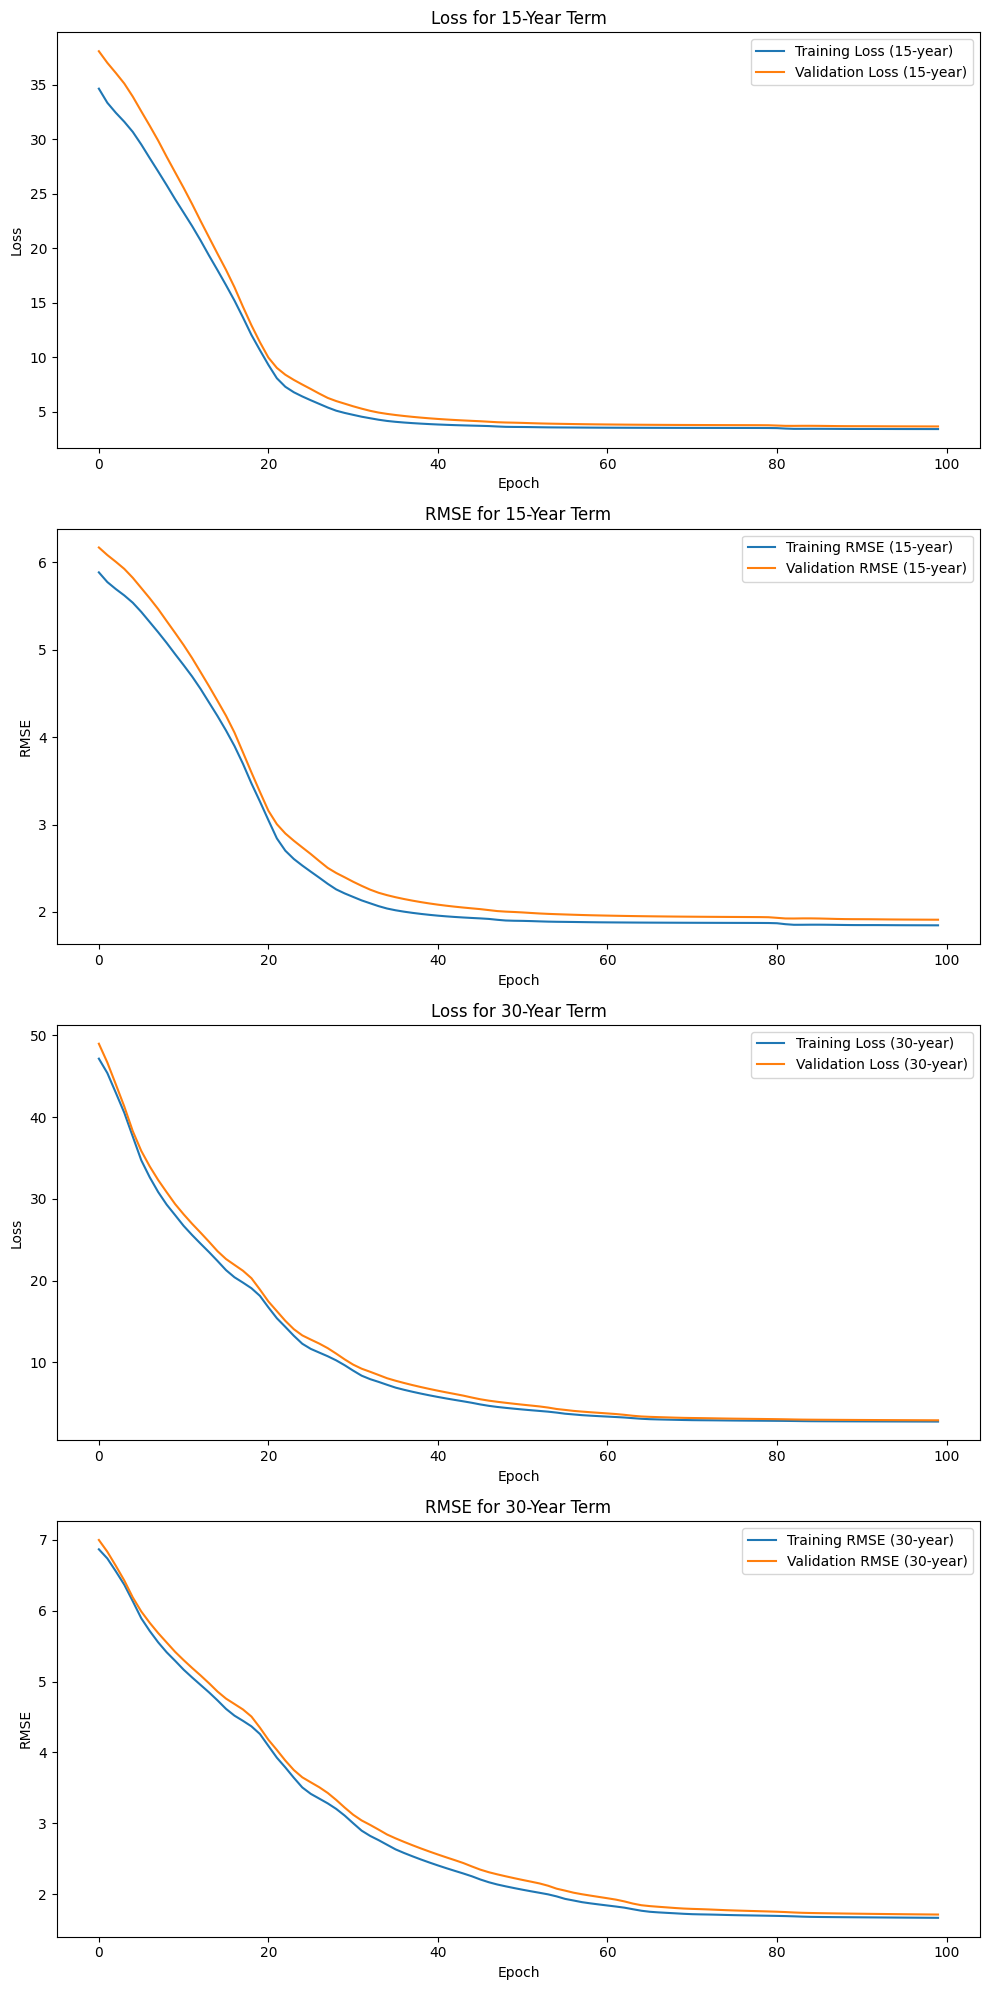

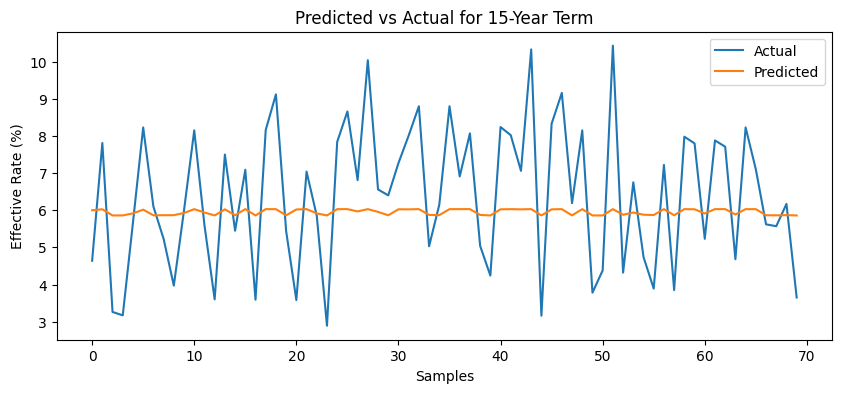

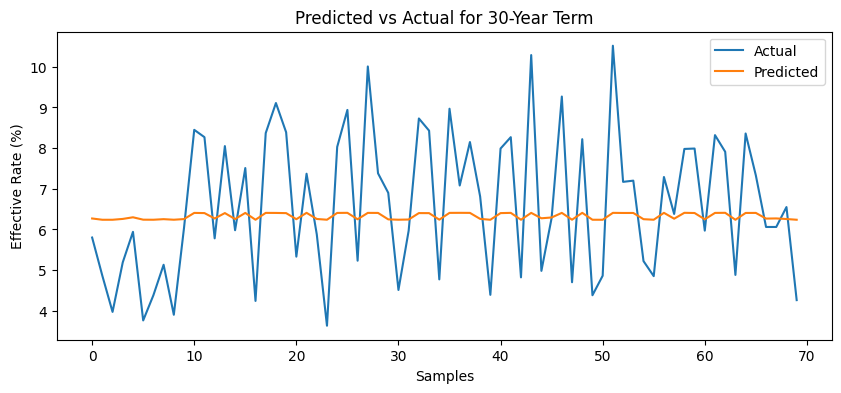

In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import math
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Load the dataset
def load_data(path):
    df = pd.read_csv(path)
    df = df.drop(index=0)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(inplace=True)  # Handling NaNs by removing; you might choose to fill them instead
    df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(Day=1))
    df.sort_values('Date', inplace=True)
    df.drop(['Year', 'Month'], axis=1, inplace=True)
    return df

# Define RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SimpleRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        return self.fc(out)

# Create sequences for modeling
def create_sequences(data, sequence_length):
    X = []
    y = []
    feature_data = data.drop(['Effective Rate (%)', 'Date'], axis=1)
    target_data = data['Effective Rate (%)']
    for i in range(len(data) - sequence_length):
        seq = feature_data.iloc[i:(i + sequence_length)].values
        label = target_data.iloc[i + sequence_length]
        X.append(seq)
        y.append(label)
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# Prepare data loaders
def prepare_data(X, y, batch_size=128, test_size=0.2):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

# Compute RMSE
def compute_rmse(predictions, targets):
    return math.sqrt(((predictions - targets) ** 2).mean())

def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, train_loss_list, val_loss_list, train_rmse_list, val_rmse_list):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_predictions, train_targets_list = [], []
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            train_predictions.extend(outputs.detach().squeeze().tolist())
            train_targets_list.extend(targets.tolist())

        train_loss /= len(train_loader.dataset)
        train_loss_list.append(train_loss)
        train_rmse = compute_rmse(np.array(train_predictions), np.array(train_targets_list))
        train_rmse_list.append(train_rmse)

        model.eval()
        val_loss = 0.0
        val_predictions, val_targets_list = [], []
        for val_inputs, val_targets in val_loader:
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs.squeeze(), val_targets).item() * val_inputs.size(0)
            val_predictions.extend(val_outputs.detach().squeeze().tolist())
            val_targets_list.extend(val_targets.tolist())

        val_loss /= len(val_loader.dataset)
        val_loss_list.append(val_loss)
        val_rmse = compute_rmse(np.array(val_predictions), np.array(val_targets_list))
        val_rmse_list.append(val_rmse)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
            print(f'Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}')

    return model

# Main execution
if __name__ == "__main__":
    dataset_path = 'Cleaned_FHFAInterestRates.csv'
    df = load_data(dataset_path)
    df_15 = df[df['Term to Maturity'] == 15].copy()
    df_30 = df[df['Term to Maturity'] == 30].copy()

    X_15, y_15 = create_sequences(df_15, 3)
    X_30, y_30 = create_sequences(df_30, 3)

    model_15 = SimpleRNN(7, 50, 1, 1)
    model_30 = SimpleRNN(7, 50, 1, 1)

    train_loader_15, val_loader_15 = prepare_data(X_15, y_15)
    train_loader_30, val_loader_30 = prepare_data(X_30, y_30)

    criterion = nn.MSELoss()
    optimizer_15 = optim.Adam(model_15.parameters(), lr=0.001)
    optimizer_30 = optim.Adam(model_30.parameters(), lr=0.001)

    train_loss_list_15 = []
    val_loss_list_15 = []
    train_rmse_list_15 = []
    val_rmse_list_15 = []

    train_loss_list_30 = []
    val_loss_list_30 = []
    train_rmse_list_30 = []
    val_rmse_list_30 = []

    trained_model_15 = train_model(model_15, train_loader_15, val_loader_15, optimizer_15, criterion, 100, train_loss_list_15, val_loss_list_15, train_rmse_list_15, val_rmse_list_15)
    trained_model_30 = train_model(model_30, train_loader_30, val_loader_30, optimizer_30, criterion, 100, train_loss_list_30, val_loss_list_30, train_rmse_list_30, val_rmse_list_30)

    # Plotting the results
    fig, axes = plt.subplots(4, 1, figsize=(10, 20))

    axes[0].plot(train_loss_list_15, label='Training Loss (15-year)')
    axes[0].plot(val_loss_list_15, label='Validation Loss (15-year)')
    axes[0].set_title('Loss for 15-Year Term')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(train_rmse_list_15, label='Training RMSE (15-year)')
    axes[1].plot(val_rmse_list_15, label='Validation RMSE (15-year)')
    axes[1].set_title('RMSE for 15-Year Term')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('RMSE')
    axes[1].legend()

    axes[2].plot(train_loss_list_30, label='Training Loss (30-year)')
    axes[2].plot(val_loss_list_30, label='Validation Loss (30-year)')
    axes[2].set_title('Loss for 30-Year Term')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')
    axes[2].legend()

    axes[3].plot(train_rmse_list_30, label='Training RMSE (30-year)')
    axes[3].plot(val_rmse_list_30, label='Validation RMSE (30-year)')
    axes[3].set_title('RMSE for 30-Year Term')
    axes[3].set_xlabel('Epoch')
    axes[3].set_ylabel('RMSE')
    axes[3].legend()

    plt.tight_layout()
    plt.show()

def plot_predictions(model, loader, title):
  model.eval()
  predictions, actuals = [], []
  with torch.no_grad():
      for inputs, targets in loader:
          outputs = model(inputs)
          predictions.extend(outputs.detach().squeeze().tolist())
          actuals.extend(targets.tolist())
  plt.figure(figsize=(10, 4))
  plt.plot(actuals, label='Actual')
  plt.plot(predictions, label='Predicted')
  plt.title(f'Predicted vs Actual for {title}')
  plt.xlabel('Samples')
  plt.ylabel('Effective Rate (%)')
  plt.legend()
  plt.show()

# Plot predicted vs actual for 15-year term
plot_predictions(trained_model_15, val_loader_15, '15-Year Term')

# Plot predicted vs actual for 30-year term
plot_predictions(trained_model_30, val_loader_30, '30-Year Term')

Best Batch Size:32

Learning Rate: 0.0001

Epoch 10/100, Training Loss: 34.7890, Validation Loss: 38.6991
Train RMSE: 5.8982, Val RMSE: 6.2209
Epoch 20/100, Training Loss: 27.1637, Validation Loss: 29.7765
Train RMSE: 5.2119, Val RMSE: 5.4568
Epoch 30/100, Training Loss: 19.7744, Validation Loss: 22.3496
Train RMSE: 4.4468, Val RMSE: 4.7275
Epoch 40/100, Training Loss: 13.0729, Validation Loss: 15.0859
Train RMSE: 3.6156, Val RMSE: 3.8841
Epoch 50/100, Training Loss: 10.1632, Validation Loss: 12.1287
Train RMSE: 3.1880, Val RMSE: 3.4826
Epoch 60/100, Training Loss: 8.7441, Validation Loss: 10.5588
Train RMSE: 2.9570, Val RMSE: 3.2494
Epoch 70/100, Training Loss: 7.7748, Validation Loss: 9.4348
Train RMSE: 2.7883, Val RMSE: 3.0716
Epoch 80/100, Training Loss: 6.9755, Validation Loss: 8.4926
Train RMSE: 2.6411, Val RMSE: 2.9142
Epoch 90/100, Training Loss: 6.3014, Validation Loss: 7.6861
Train RMSE: 2.5103, Val RMSE: 2.7724
Epoch 100/100, Training Loss: 5.7297, Validation Loss: 6.9881
Train RMSE: 2.3937, Val RMSE: 2.6435
Epoch 10

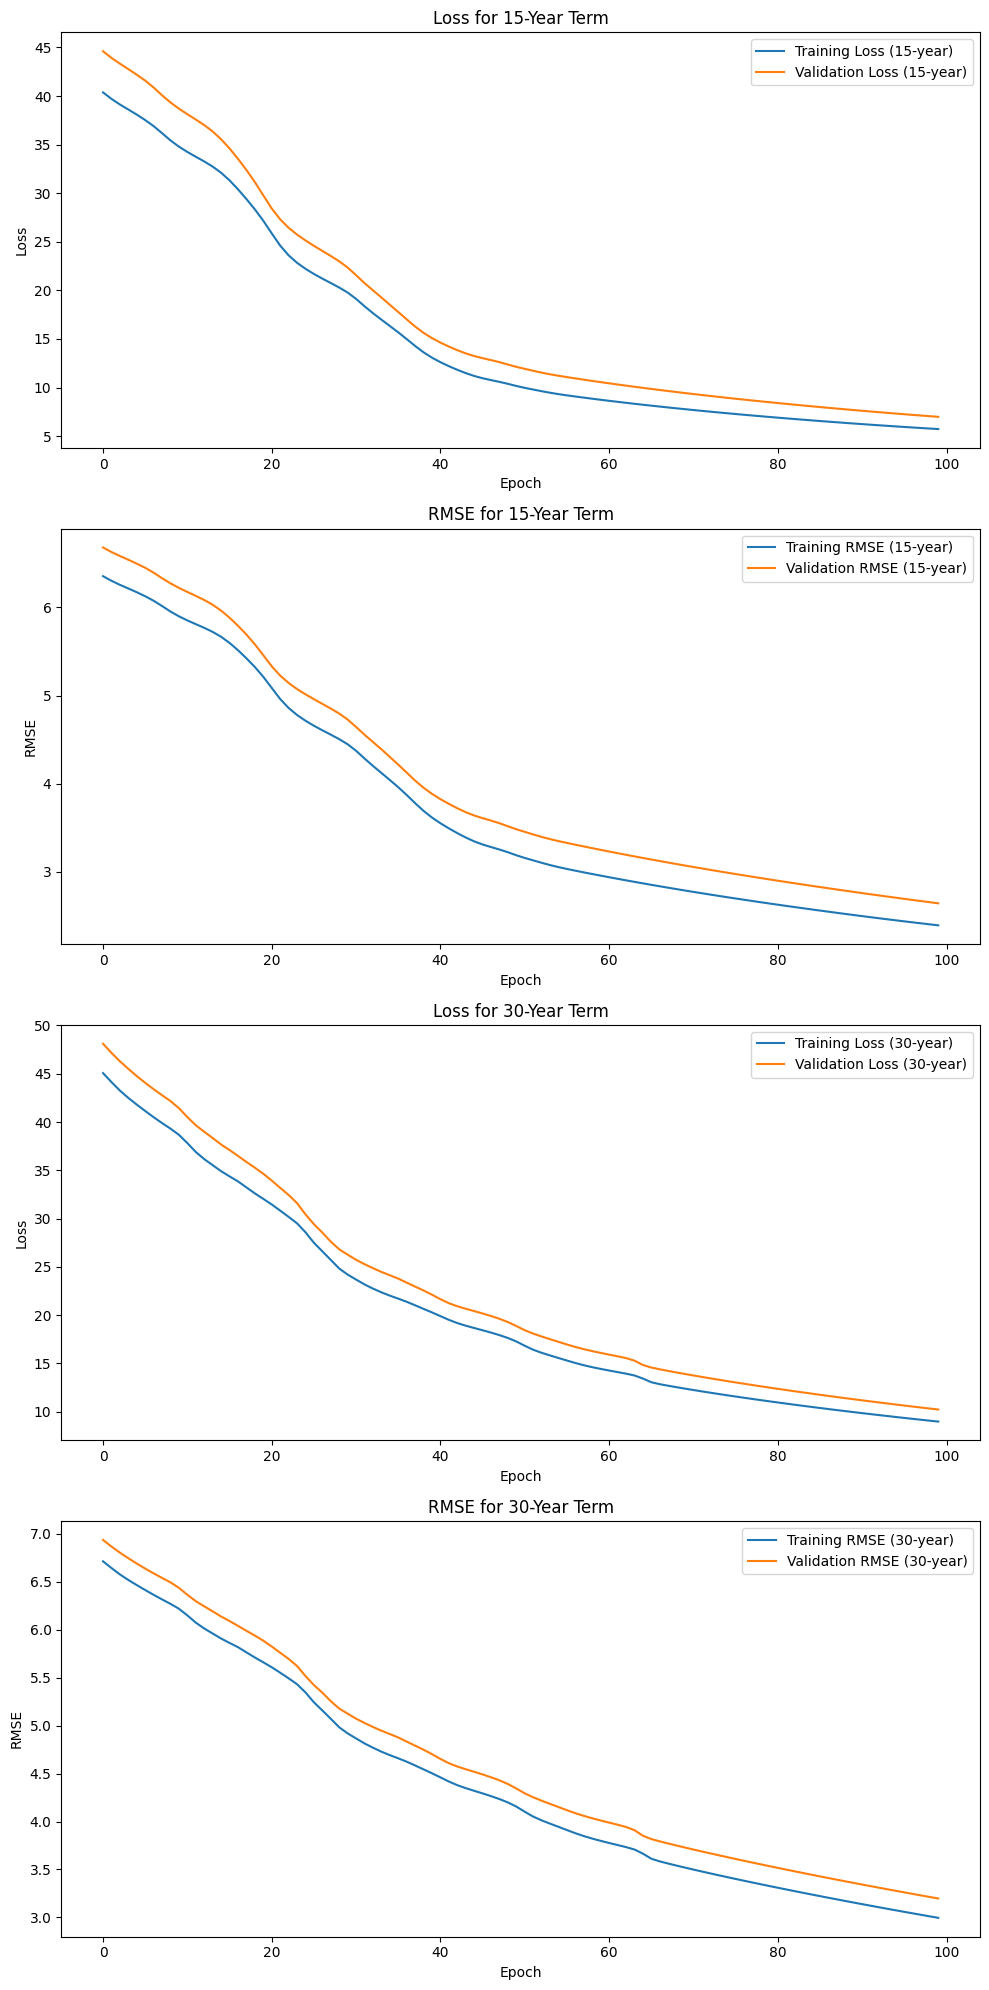

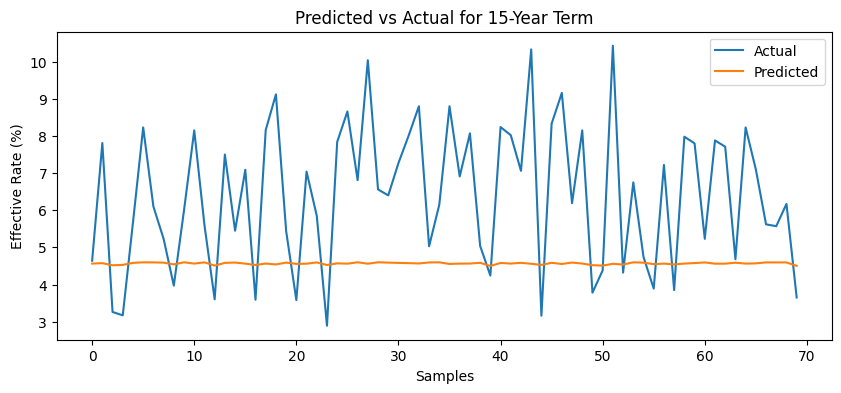

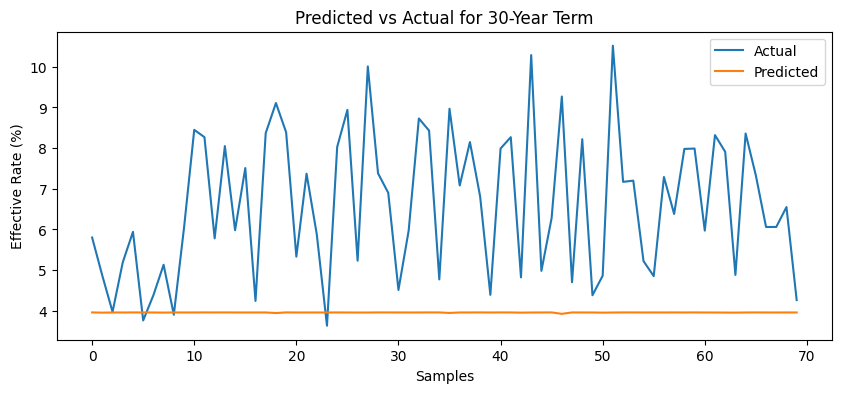

In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import math
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Load the dataset
def load_data(path):
    df = pd.read_csv(path)
    df = df.drop(index=0)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(inplace=True)  # Handling NaNs by removing; you might choose to fill them instead
    df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(Day=1))
    df.sort_values('Date', inplace=True)
    df.drop(['Year', 'Month'], axis=1, inplace=True)
    return df

# Define RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SimpleRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        return self.fc(out)

# Create sequences for modeling
def create_sequences(data, sequence_length):
    X = []
    y = []
    feature_data = data.drop(['Effective Rate (%)', 'Date'], axis=1)
    target_data = data['Effective Rate (%)']
    for i in range(len(data) - sequence_length):
        seq = feature_data.iloc[i:(i + sequence_length)].values
        label = target_data.iloc[i + sequence_length]
        X.append(seq)
        y.append(label)
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# Prepare data loaders
def prepare_data(X, y, batch_size=32, test_size=0.2):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

# Compute RMSE
def compute_rmse(predictions, targets):
    return math.sqrt(((predictions - targets) ** 2).mean())

def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, train_loss_list, val_loss_list, train_rmse_list, val_rmse_list):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_predictions, train_targets_list = [], []
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            train_predictions.extend(outputs.detach().squeeze().tolist())
            train_targets_list.extend(targets.tolist())

        train_loss /= len(train_loader.dataset)
        train_loss_list.append(train_loss)
        train_rmse = compute_rmse(np.array(train_predictions), np.array(train_targets_list))
        train_rmse_list.append(train_rmse)

        model.eval()
        val_loss = 0.0
        val_predictions, val_targets_list = [], []
        for val_inputs, val_targets in val_loader:
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs.squeeze(), val_targets).item() * val_inputs.size(0)
            val_predictions.extend(val_outputs.detach().squeeze().tolist())
            val_targets_list.extend(val_targets.tolist())

        val_loss /= len(val_loader.dataset)
        val_loss_list.append(val_loss)
        val_rmse = compute_rmse(np.array(val_predictions), np.array(val_targets_list))
        val_rmse_list.append(val_rmse)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
            print(f'Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}')

    return model

# Main execution
if __name__ == "__main__":
    dataset_path = 'Cleaned_FHFAInterestRates.csv'
    df = load_data(dataset_path)
    df_15 = df[df['Term to Maturity'] == 15].copy()
    df_30 = df[df['Term to Maturity'] == 30].copy()

    X_15, y_15 = create_sequences(df_15, 3)
    X_30, y_30 = create_sequences(df_30, 3)

    model_15 = SimpleRNN(7, 50, 1, 1)
    model_30 = SimpleRNN(7, 50, 1, 1)

    train_loader_15, val_loader_15 = prepare_data(X_15, y_15)
    train_loader_30, val_loader_30 = prepare_data(X_30, y_30)

    criterion = nn.MSELoss()
    optimizer_15 = optim.Adam(model_15.parameters(), lr=0.0001)
    optimizer_30 = optim.Adam(model_30.parameters(), lr=0.0001)

    train_loss_list_15 = []
    val_loss_list_15 = []
    train_rmse_list_15 = []
    val_rmse_list_15 = []

    train_loss_list_30 = []
    val_loss_list_30 = []
    train_rmse_list_30 = []
    val_rmse_list_30 = []

    trained_model_15 = train_model(model_15, train_loader_15, val_loader_15, optimizer_15, criterion, 100, train_loss_list_15, val_loss_list_15, train_rmse_list_15, val_rmse_list_15)
    trained_model_30 = train_model(model_30, train_loader_30, val_loader_30, optimizer_30, criterion, 100, train_loss_list_30, val_loss_list_30, train_rmse_list_30, val_rmse_list_30)

    # Plotting the results
    fig, axes = plt.subplots(4, 1, figsize=(10, 20))

    axes[0].plot(train_loss_list_15, label='Training Loss (15-year)')
    axes[0].plot(val_loss_list_15, label='Validation Loss (15-year)')
    axes[0].set_title('Loss for 15-Year Term')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(train_rmse_list_15, label='Training RMSE (15-year)')
    axes[1].plot(val_rmse_list_15, label='Validation RMSE (15-year)')
    axes[1].set_title('RMSE for 15-Year Term')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('RMSE')
    axes[1].legend()

    axes[2].plot(train_loss_list_30, label='Training Loss (30-year)')
    axes[2].plot(val_loss_list_30, label='Validation Loss (30-year)')
    axes[2].set_title('Loss for 30-Year Term')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')
    axes[2].legend()

    axes[3].plot(train_rmse_list_30, label='Training RMSE (30-year)')
    axes[3].plot(val_rmse_list_30, label='Validation RMSE (30-year)')
    axes[3].set_title('RMSE for 30-Year Term')
    axes[3].set_xlabel('Epoch')
    axes[3].set_ylabel('RMSE')
    axes[3].legend()

    plt.tight_layout()
    plt.show()

def plot_predictions(model, loader, title):
  model.eval()
  predictions, actuals = [], []
  with torch.no_grad():
      for inputs, targets in loader:
          outputs = model(inputs)
          predictions.extend(outputs.detach().squeeze().tolist())
          actuals.extend(targets.tolist())
  plt.figure(figsize=(10, 4))
  plt.plot(actuals, label='Actual')
  plt.plot(predictions, label='Predicted')
  plt.title(f'Predicted vs Actual for {title}')
  plt.xlabel('Samples')
  plt.ylabel('Effective Rate (%)')
  plt.legend()
  plt.show()

# Plot predicted vs actual for 15-year term
plot_predictions(trained_model_15, val_loader_15, '15-Year Term')

# Plot predicted vs actual for 30-year term
plot_predictions(trained_model_30, val_loader_30, '30-Year Term')

LR 0.01

Epoch 10/100, Training Loss: 3.6420, Validation Loss: 3.8755
Train RMSE: 1.9084, Val RMSE: 1.9686
Epoch 20/100, Training Loss: 3.6360, Validation Loss: 3.8379
Train RMSE: 1.9068, Val RMSE: 1.9591
Epoch 30/100, Training Loss: 3.6363, Validation Loss: 3.8374
Train RMSE: 1.9069, Val RMSE: 1.9589
Epoch 40/100, Training Loss: 3.6365, Validation Loss: 3.8370
Train RMSE: 1.9070, Val RMSE: 1.9588
Epoch 50/100, Training Loss: 3.6367, Validation Loss: 3.8367
Train RMSE: 1.9070, Val RMSE: 1.9587
Epoch 60/100, Training Loss: 3.6369, Validation Loss: 3.8364
Train RMSE: 1.9071, Val RMSE: 1.9587
Epoch 70/100, Training Loss: 3.6371, Validation Loss: 3.8361
Train RMSE: 1.9071, Val RMSE: 1.9586
Epoch 80/100, Training Loss: 3.6372, Validation Loss: 3.8359
Train RMSE: 1.9071, Val RMSE: 1.9585
Epoch 90/100, Training Loss: 3.6374, Validation Loss: 3.8356
Train RMSE: 1.9072, Val RMSE: 1.9585
Epoch 100/100, Training Loss: 3.6375, Validation Loss: 3.8354
Train RMSE: 1.9072, Val RMSE: 1.9584
Epoch 10/100, Train

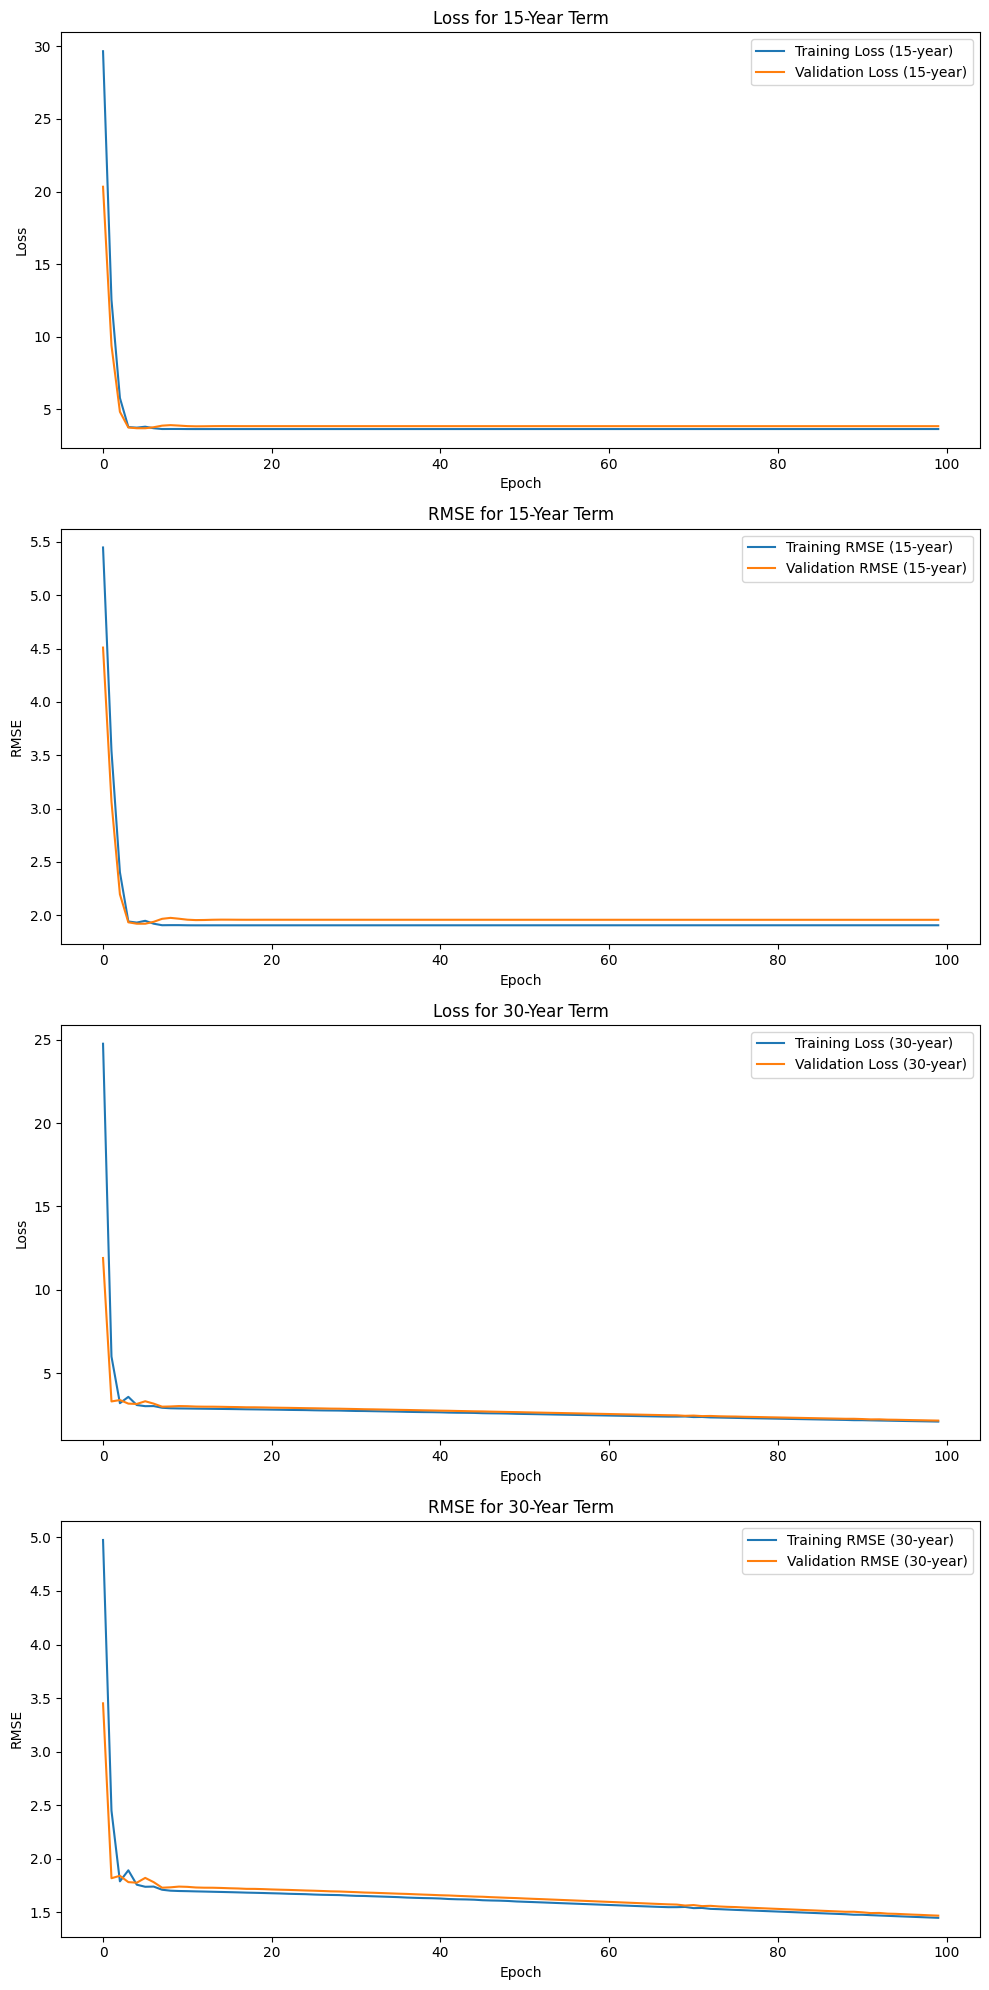

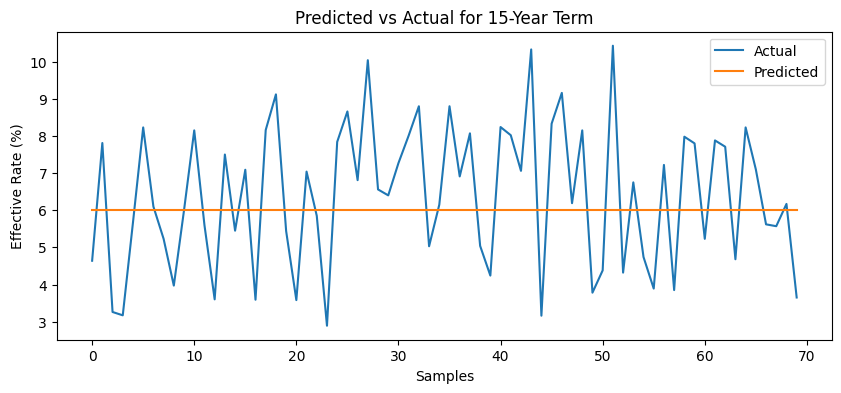

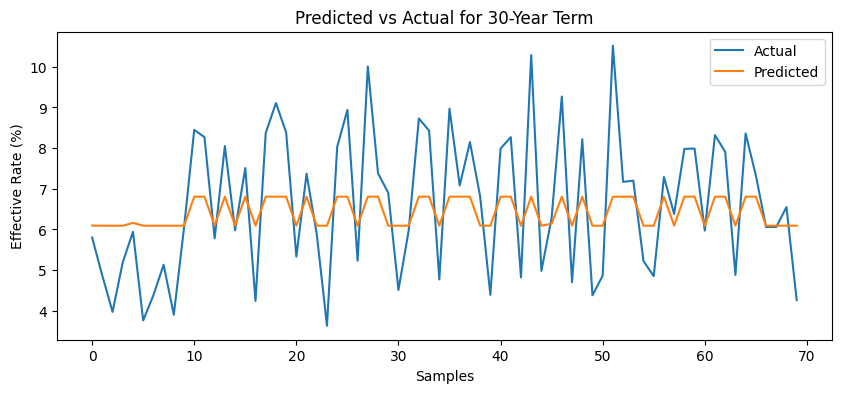

In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import math
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Load the dataset
def load_data(path):
    df = pd.read_csv(path)
    df = df.drop(index=0)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(inplace=True)  # Handling NaNs by removing; you might choose to fill them instead
    df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(Day=1))
    df.sort_values('Date', inplace=True)
    df.drop(['Year', 'Month'], axis=1, inplace=True)
    return df

# Define RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SimpleRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        return self.fc(out)

# Create sequences for modeling
def create_sequences(data, sequence_length):
    X = []
    y = []
    feature_data = data.drop(['Effective Rate (%)', 'Date'], axis=1)
    target_data = data['Effective Rate (%)']
    for i in range(len(data) - sequence_length):
        seq = feature_data.iloc[i:(i + sequence_length)].values
        label = target_data.iloc[i + sequence_length]
        X.append(seq)
        y.append(label)
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# Prepare data loaders
def prepare_data(X, y, batch_size=32, test_size=0.2):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

# Compute RMSE
def compute_rmse(predictions, targets):
    return math.sqrt(((predictions - targets) ** 2).mean())

def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, train_loss_list, val_loss_list, train_rmse_list, val_rmse_list):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_predictions, train_targets_list = [], []
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            train_predictions.extend(outputs.detach().squeeze().tolist())
            train_targets_list.extend(targets.tolist())

        train_loss /= len(train_loader.dataset)
        train_loss_list.append(train_loss)
        train_rmse = compute_rmse(np.array(train_predictions), np.array(train_targets_list))
        train_rmse_list.append(train_rmse)

        model.eval()
        val_loss = 0.0
        val_predictions, val_targets_list = [], []
        for val_inputs, val_targets in val_loader:
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs.squeeze(), val_targets).item() * val_inputs.size(0)
            val_predictions.extend(val_outputs.detach().squeeze().tolist())
            val_targets_list.extend(val_targets.tolist())

        val_loss /= len(val_loader.dataset)
        val_loss_list.append(val_loss)
        val_rmse = compute_rmse(np.array(val_predictions), np.array(val_targets_list))
        val_rmse_list.append(val_rmse)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
            print(f'Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}')

    return model

# Main execution
if __name__ == "__main__":
    dataset_path = 'Cleaned_FHFAInterestRates.csv'
    df = load_data(dataset_path)
    df_15 = df[df['Term to Maturity'] == 15].copy()
    df_30 = df[df['Term to Maturity'] == 30].copy()

    X_15, y_15 = create_sequences(df_15, 3)
    X_30, y_30 = create_sequences(df_30, 3)

    model_15 = SimpleRNN(7, 50, 1, 1)
    model_30 = SimpleRNN(7, 50, 1, 1)

    train_loader_15, val_loader_15 = prepare_data(X_15, y_15)
    train_loader_30, val_loader_30 = prepare_data(X_30, y_30)

    criterion = nn.MSELoss()
    optimizer_15 = optim.Adam(model_15.parameters(), lr=0.01)
    optimizer_30 = optim.Adam(model_30.parameters(), lr=0.01)

    train_loss_list_15 = []
    val_loss_list_15 = []
    train_rmse_list_15 = []
    val_rmse_list_15 = []

    train_loss_list_30 = []
    val_loss_list_30 = []
    train_rmse_list_30 = []
    val_rmse_list_30 = []

    trained_model_15 = train_model(model_15, train_loader_15, val_loader_15, optimizer_15, criterion, 100, train_loss_list_15, val_loss_list_15, train_rmse_list_15, val_rmse_list_15)
    trained_model_30 = train_model(model_30, train_loader_30, val_loader_30, optimizer_30, criterion, 100, train_loss_list_30, val_loss_list_30, train_rmse_list_30, val_rmse_list_30)

    # Plotting the results
    fig, axes = plt.subplots(4, 1, figsize=(10, 20))

    axes[0].plot(train_loss_list_15, label='Training Loss (15-year)')
    axes[0].plot(val_loss_list_15, label='Validation Loss (15-year)')
    axes[0].set_title('Loss for 15-Year Term')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(train_rmse_list_15, label='Training RMSE (15-year)')
    axes[1].plot(val_rmse_list_15, label='Validation RMSE (15-year)')
    axes[1].set_title('RMSE for 15-Year Term')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('RMSE')
    axes[1].legend()

    axes[2].plot(train_loss_list_30, label='Training Loss (30-year)')
    axes[2].plot(val_loss_list_30, label='Validation Loss (30-year)')
    axes[2].set_title('Loss for 30-Year Term')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')
    axes[2].legend()

    axes[3].plot(train_rmse_list_30, label='Training RMSE (30-year)')
    axes[3].plot(val_rmse_list_30, label='Validation RMSE (30-year)')
    axes[3].set_title('RMSE for 30-Year Term')
    axes[3].set_xlabel('Epoch')
    axes[3].set_ylabel('RMSE')
    axes[3].legend()

    plt.tight_layout()
    plt.show()

def plot_predictions(model, loader, title):
  model.eval()
  predictions, actuals = [], []
  with torch.no_grad():
      for inputs, targets in loader:
          outputs = model(inputs)
          predictions.extend(outputs.detach().squeeze().tolist())
          actuals.extend(targets.tolist())
  plt.figure(figsize=(10, 4))
  plt.plot(actuals, label='Actual')
  plt.plot(predictions, label='Predicted')
  plt.title(f'Predicted vs Actual for {title}')
  plt.xlabel('Samples')
  plt.ylabel('Effective Rate (%)')
  plt.legend()
  plt.show()

# Plot predicted vs actual for 15-year term
plot_predictions(trained_model_15, val_loader_15, '15-Year Term')

# Plot predicted vs actual for 30-year term
plot_predictions(trained_model_30, val_loader_30, '30-Year Term')

Best LR: 0.001

Hidden Size: 25

Epoch 10/100, Training Loss: 21.3505, Validation Loss: 23.8898
Train RMSE: 4.6207, Val RMSE: 4.8877
Epoch 20/100, Training Loss: 10.4510, Validation Loss: 12.1732
Train RMSE: 3.2328, Val RMSE: 3.4890
Epoch 30/100, Training Loss: 5.1213, Validation Loss: 6.0640
Train RMSE: 2.2630, Val RMSE: 2.4625
Epoch 40/100, Training Loss: 3.9356, Validation Loss: 4.4936
Train RMSE: 1.9838, Val RMSE: 2.1198
Epoch 50/100, Training Loss: 3.6850, Validation Loss: 4.0342
Train RMSE: 1.9196, Val RMSE: 2.0085
Epoch 60/100, Training Loss: 3.6349, Validation Loss: 3.8853
Train RMSE: 1.9065, Val RMSE: 1.9711
Epoch 70/100, Training Loss: 3.5802, Validation Loss: 3.7826
Train RMSE: 1.8921, Val RMSE: 1.9449
Epoch 80/100, Training Loss: 3.5142, Validation Loss: 3.6967
Train RMSE: 1.8746, Val RMSE: 1.9227
Epoch 90/100, Training Loss: 3.4429, Validation Loss: 3.6178
Train RMSE: 1.8555, Val RMSE: 1.9020
Epoch 100/100, Training Loss: 3.3395, Validation Loss: 3.2667
Train RMSE: 1.8274, Val RMSE: 1.8074
Epoch 10/100, T

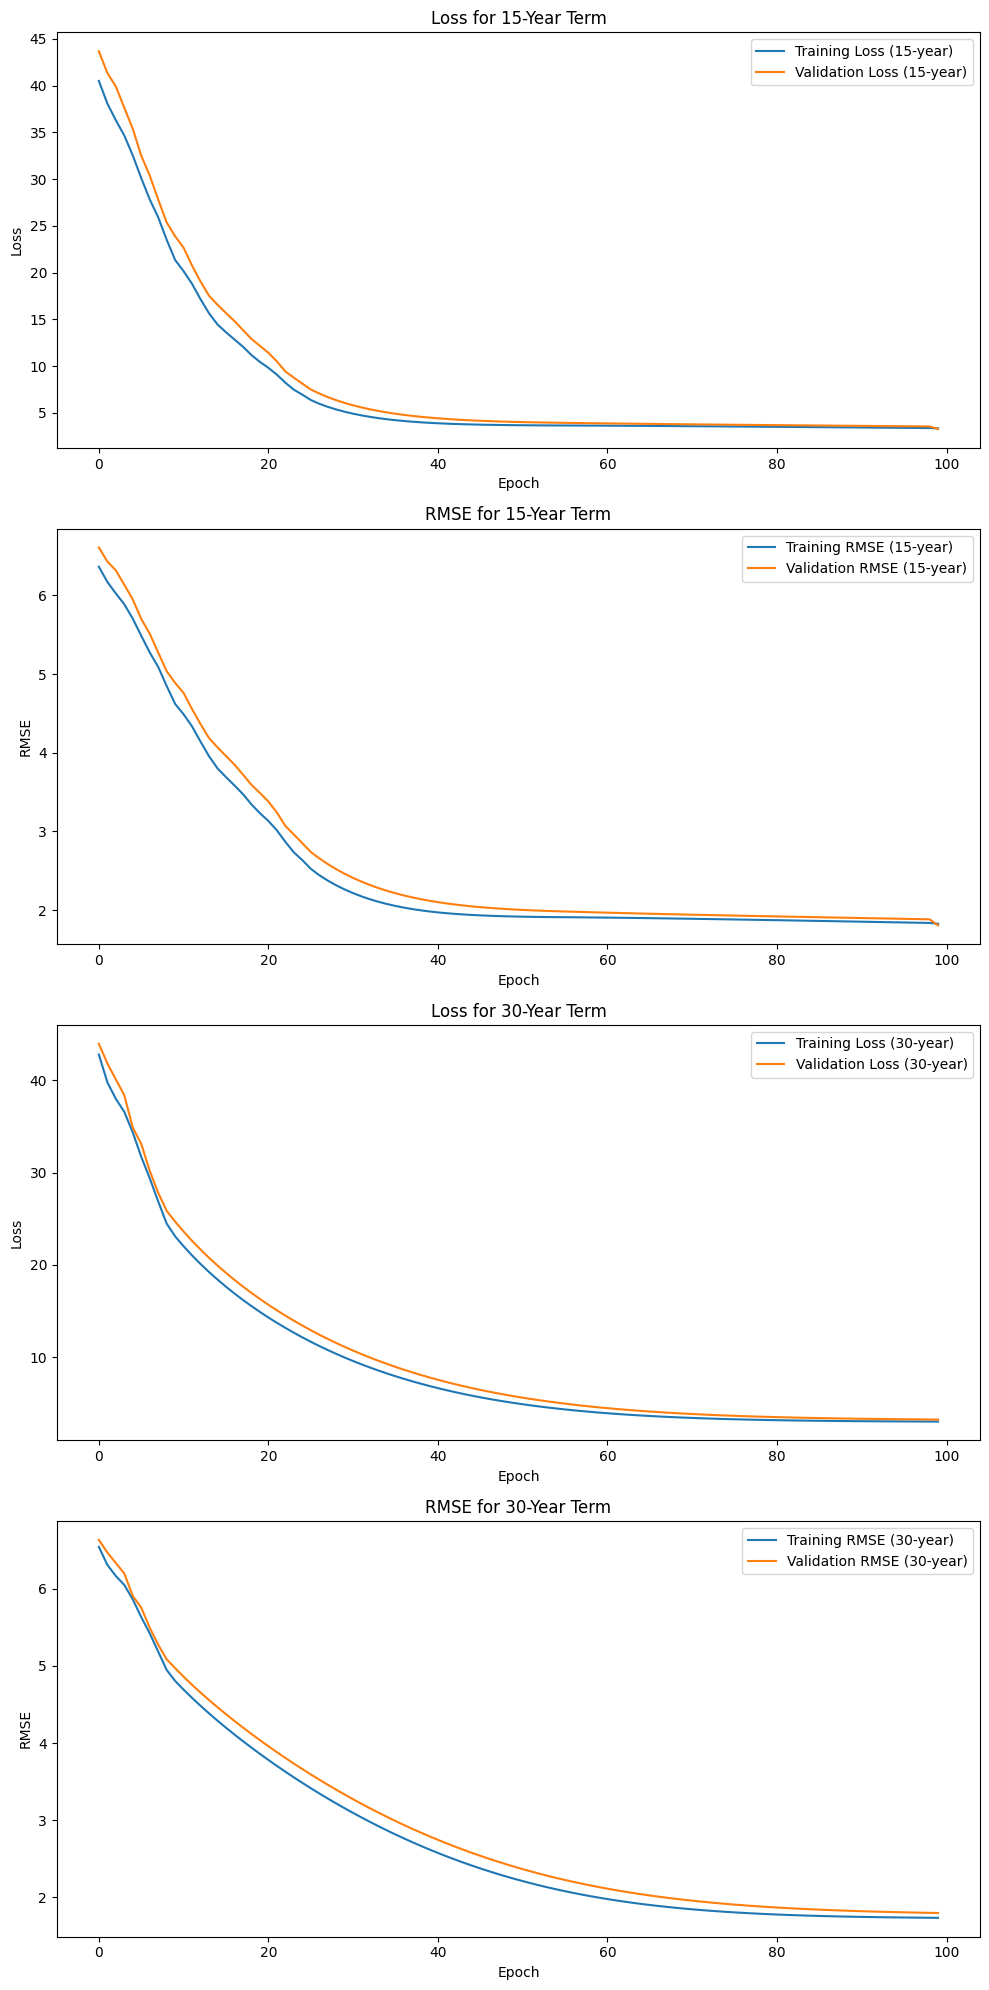

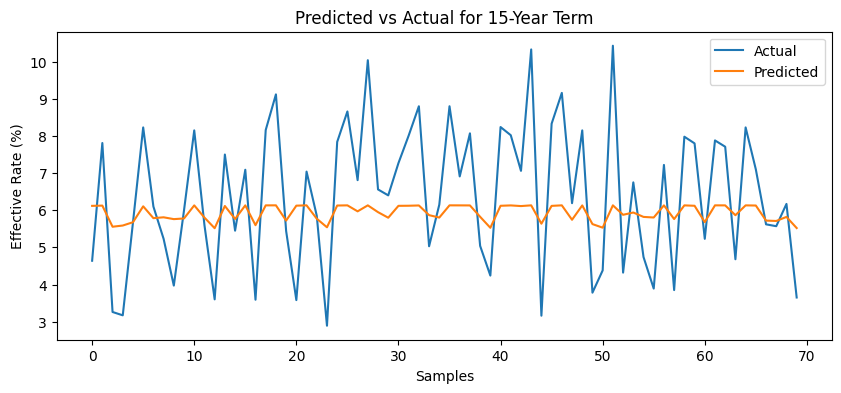

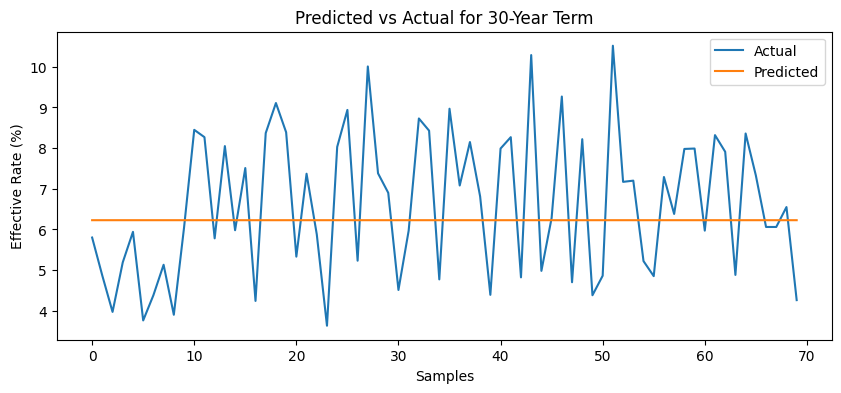

In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import math
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Load the dataset
def load_data(path):
    df = pd.read_csv(path)
    df = df.drop(index=0)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(inplace=True)  # Handling NaNs by removing; you might choose to fill them instead
    df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(Day=1))
    df.sort_values('Date', inplace=True)
    df.drop(['Year', 'Month'], axis=1, inplace=True)
    return df

# Define RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SimpleRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        return self.fc(out)

# Create sequences for modeling
def create_sequences(data, sequence_length):
    X = []
    y = []
    feature_data = data.drop(['Effective Rate (%)', 'Date'], axis=1)
    target_data = data['Effective Rate (%)']
    for i in range(len(data) - sequence_length):
        seq = feature_data.iloc[i:(i + sequence_length)].values
        label = target_data.iloc[i + sequence_length]
        X.append(seq)
        y.append(label)
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# Prepare data loaders
def prepare_data(X, y, batch_size=32, test_size=0.2):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

# Compute RMSE
def compute_rmse(predictions, targets):
    return math.sqrt(((predictions - targets) ** 2).mean())

def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, train_loss_list, val_loss_list, train_rmse_list, val_rmse_list):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_predictions, train_targets_list = [], []
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            train_predictions.extend(outputs.detach().squeeze().tolist())
            train_targets_list.extend(targets.tolist())

        train_loss /= len(train_loader.dataset)
        train_loss_list.append(train_loss)
        train_rmse = compute_rmse(np.array(train_predictions), np.array(train_targets_list))
        train_rmse_list.append(train_rmse)

        model.eval()
        val_loss = 0.0
        val_predictions, val_targets_list = [], []
        for val_inputs, val_targets in val_loader:
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs.squeeze(), val_targets).item() * val_inputs.size(0)
            val_predictions.extend(val_outputs.detach().squeeze().tolist())
            val_targets_list.extend(val_targets.tolist())

        val_loss /= len(val_loader.dataset)
        val_loss_list.append(val_loss)
        val_rmse = compute_rmse(np.array(val_predictions), np.array(val_targets_list))
        val_rmse_list.append(val_rmse)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
            print(f'Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}')

    return model

# Main execution
if __name__ == "__main__":
    dataset_path = 'Cleaned_FHFAInterestRates.csv'
    df = load_data(dataset_path)
    df_15 = df[df['Term to Maturity'] == 15].copy()
    df_30 = df[df['Term to Maturity'] == 30].copy()

    X_15, y_15 = create_sequences(df_15, 3)
    X_30, y_30 = create_sequences(df_30, 3)

    model_15 = SimpleRNN(7, 25, 1, 1)
    model_30 = SimpleRNN(7, 25, 1, 1)

    train_loader_15, val_loader_15 = prepare_data(X_15, y_15)
    train_loader_30, val_loader_30 = prepare_data(X_30, y_30)

    criterion = nn.MSELoss()
    optimizer_15 = optim.Adam(model_15.parameters(), lr=0.001)
    optimizer_30 = optim.Adam(model_30.parameters(), lr=0.001)

    train_loss_list_15 = []
    val_loss_list_15 = []
    train_rmse_list_15 = []
    val_rmse_list_15 = []

    train_loss_list_30 = []
    val_loss_list_30 = []
    train_rmse_list_30 = []
    val_rmse_list_30 = []

    trained_model_15 = train_model(model_15, train_loader_15, val_loader_15, optimizer_15, criterion, 100, train_loss_list_15, val_loss_list_15, train_rmse_list_15, val_rmse_list_15)
    trained_model_30 = train_model(model_30, train_loader_30, val_loader_30, optimizer_30, criterion, 100, train_loss_list_30, val_loss_list_30, train_rmse_list_30, val_rmse_list_30)

    # Plotting the results
    fig, axes = plt.subplots(4, 1, figsize=(10, 20))

    axes[0].plot(train_loss_list_15, label='Training Loss (15-year)')
    axes[0].plot(val_loss_list_15, label='Validation Loss (15-year)')
    axes[0].set_title('Loss for 15-Year Term')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(train_rmse_list_15, label='Training RMSE (15-year)')
    axes[1].plot(val_rmse_list_15, label='Validation RMSE (15-year)')
    axes[1].set_title('RMSE for 15-Year Term')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('RMSE')
    axes[1].legend()

    axes[2].plot(train_loss_list_30, label='Training Loss (30-year)')
    axes[2].plot(val_loss_list_30, label='Validation Loss (30-year)')
    axes[2].set_title('Loss for 30-Year Term')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')
    axes[2].legend()

    axes[3].plot(train_rmse_list_30, label='Training RMSE (30-year)')
    axes[3].plot(val_rmse_list_30, label='Validation RMSE (30-year)')
    axes[3].set_title('RMSE for 30-Year Term')
    axes[3].set_xlabel('Epoch')
    axes[3].set_ylabel('RMSE')
    axes[3].legend()

    plt.tight_layout()
    plt.show()

def plot_predictions(model, loader, title):
  model.eval()
  predictions, actuals = [], []
  with torch.no_grad():
      for inputs, targets in loader:
          outputs = model(inputs)
          predictions.extend(outputs.detach().squeeze().tolist())
          actuals.extend(targets.tolist())
  plt.figure(figsize=(10, 4))
  plt.plot(actuals, label='Actual')
  plt.plot(predictions, label='Predicted')
  plt.title(f'Predicted vs Actual for {title}')
  plt.xlabel('Samples')
  plt.ylabel('Effective Rate (%)')
  plt.legend()
  plt.show()

# Plot predicted vs actual for 15-year term
plot_predictions(trained_model_15, val_loader_15, '15-Year Term')

# Plot predicted vs actual for 30-year term
plot_predictions(trained_model_30, val_loader_30, '30-Year Term')

Hidden Size:100

Epoch 10/100, Training Loss: 3.0334, Validation Loss: 3.0633
Train RMSE: 1.7417, Val RMSE: 1.7502
Epoch 20/100, Training Loss: 1.4085, Validation Loss: 1.4052
Train RMSE: 1.1868, Val RMSE: 1.1854
Epoch 30/100, Training Loss: 0.7274, Validation Loss: 0.8386
Train RMSE: 0.8529, Val RMSE: 0.9157
Epoch 40/100, Training Loss: 0.4360, Validation Loss: 0.5768
Train RMSE: 0.6603, Val RMSE: 0.7595
Epoch 50/100, Training Loss: 0.2967, Validation Loss: 0.4389
Train RMSE: 0.5447, Val RMSE: 0.6625
Epoch 60/100, Training Loss: 0.2323, Validation Loss: 0.3690
Train RMSE: 0.4819, Val RMSE: 0.6075
Epoch 70/100, Training Loss: 0.1927, Validation Loss: 0.2995
Train RMSE: 0.4389, Val RMSE: 0.5472
Epoch 80/100, Training Loss: 0.1698, Validation Loss: 0.2717
Train RMSE: 0.4121, Val RMSE: 0.5213
Epoch 90/100, Training Loss: 0.1494, Validation Loss: 0.2444
Train RMSE: 0.3865, Val RMSE: 0.4944
Epoch 100/100, Training Loss: 0.1213, Validation Loss: 0.2125
Train RMSE: 0.3483, Val RMSE: 0.4609
Epoch 10/100, Train

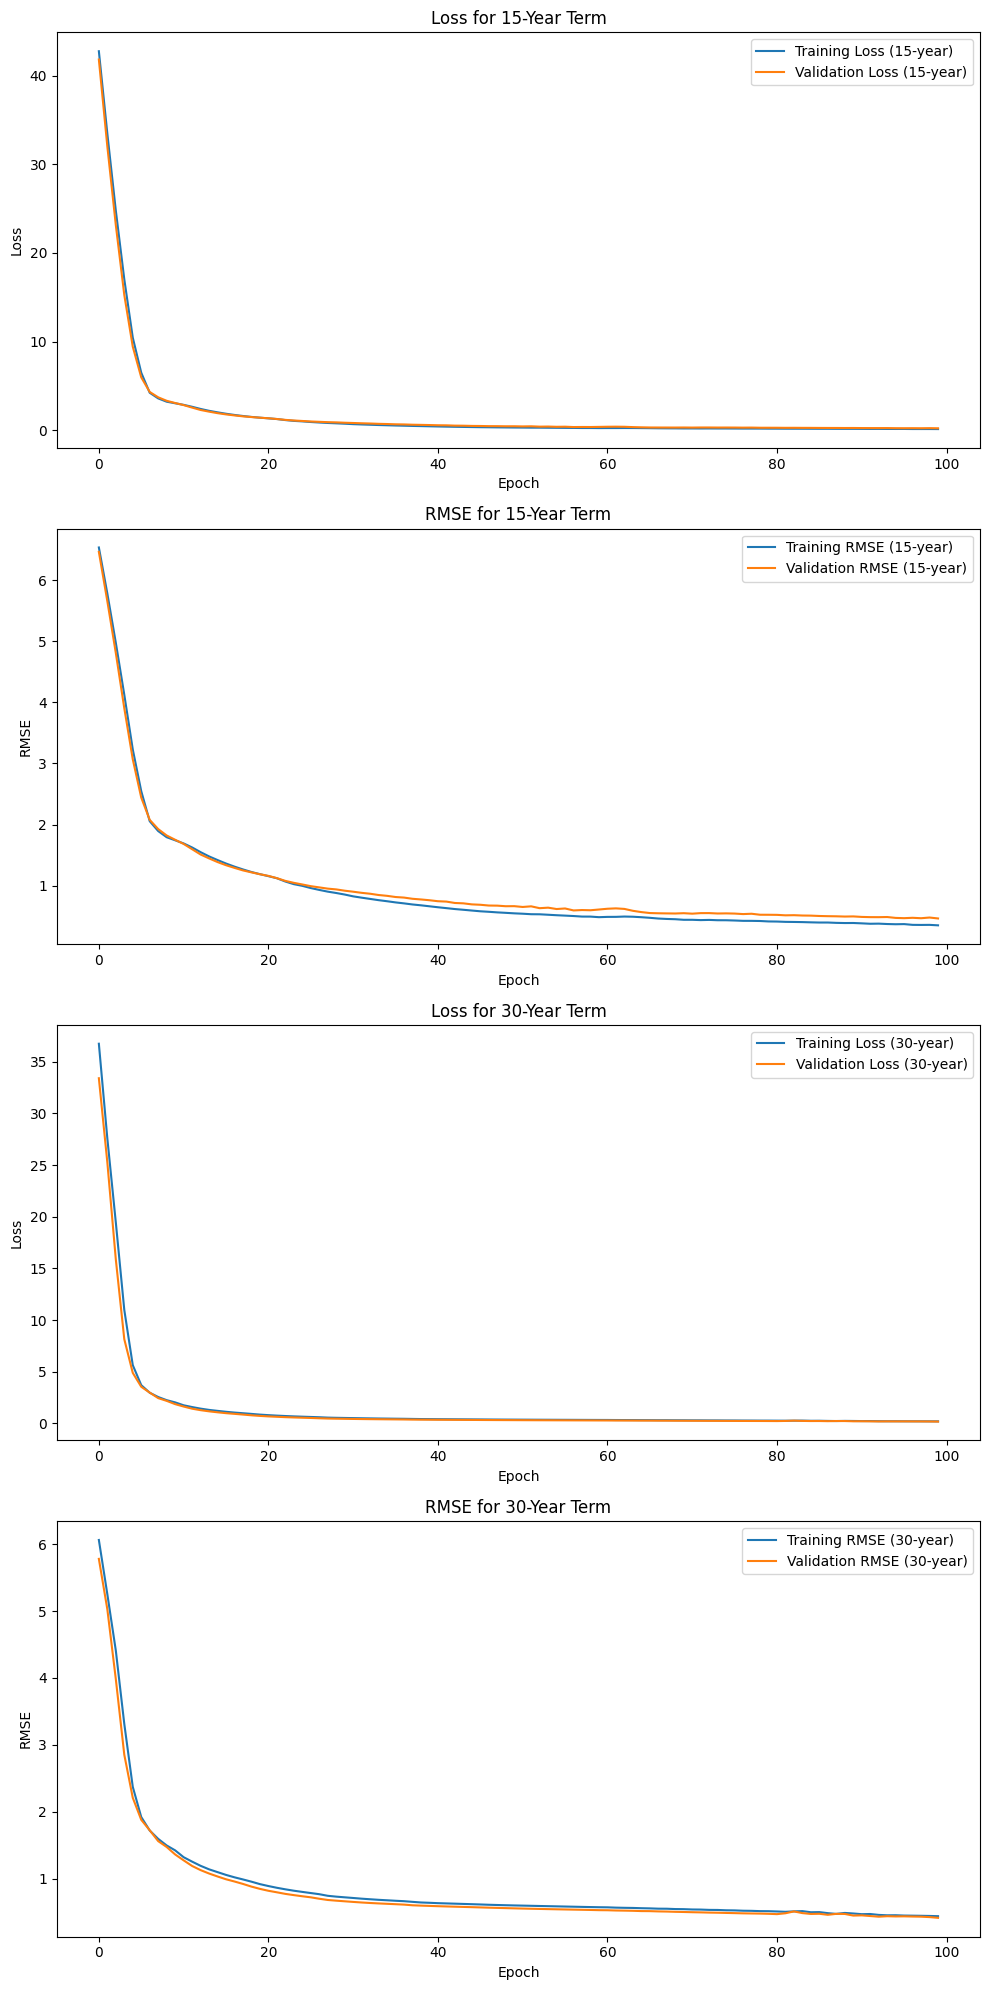

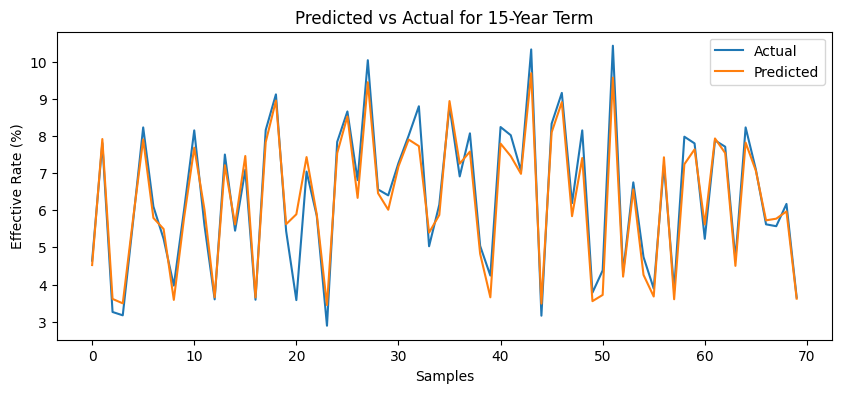

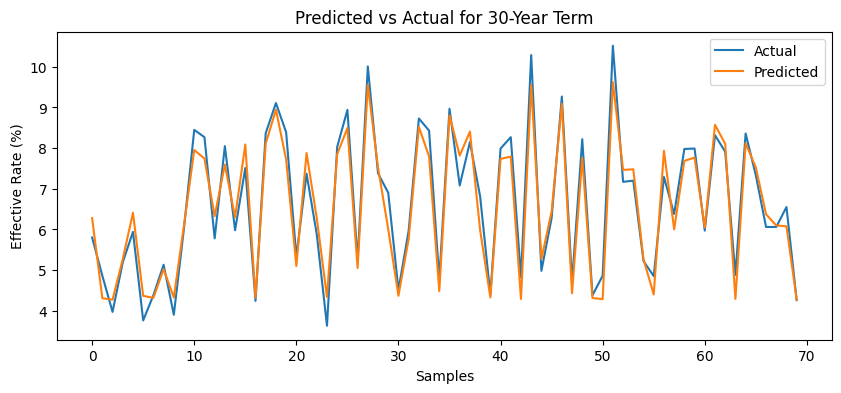

In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import math
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Load the dataset
def load_data(path):
    df = pd.read_csv(path)
    df = df.drop(index=0)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(inplace=True)  # Handling NaNs by removing; you might choose to fill them instead
    df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(Day=1))
    df.sort_values('Date', inplace=True)
    df.drop(['Year', 'Month'], axis=1, inplace=True)
    return df

# Define RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SimpleRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        return self.fc(out)

# Create sequences for modeling
def create_sequences(data, sequence_length):
    X = []
    y = []
    feature_data = data.drop(['Effective Rate (%)', 'Date'], axis=1)
    target_data = data['Effective Rate (%)']
    for i in range(len(data) - sequence_length):
        seq = feature_data.iloc[i:(i + sequence_length)].values
        label = target_data.iloc[i + sequence_length]
        X.append(seq)
        y.append(label)
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# Prepare data loaders
def prepare_data(X, y, batch_size=32, test_size=0.2):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

# Compute RMSE
def compute_rmse(predictions, targets):
    return math.sqrt(((predictions - targets) ** 2).mean())

def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, train_loss_list, val_loss_list, train_rmse_list, val_rmse_list):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_predictions, train_targets_list = [], []
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            train_predictions.extend(outputs.detach().squeeze().tolist())
            train_targets_list.extend(targets.tolist())

        train_loss /= len(train_loader.dataset)
        train_loss_list.append(train_loss)
        train_rmse = compute_rmse(np.array(train_predictions), np.array(train_targets_list))
        train_rmse_list.append(train_rmse)

        model.eval()
        val_loss = 0.0
        val_predictions, val_targets_list = [], []
        for val_inputs, val_targets in val_loader:
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs.squeeze(), val_targets).item() * val_inputs.size(0)
            val_predictions.extend(val_outputs.detach().squeeze().tolist())
            val_targets_list.extend(val_targets.tolist())

        val_loss /= len(val_loader.dataset)
        val_loss_list.append(val_loss)
        val_rmse = compute_rmse(np.array(val_predictions), np.array(val_targets_list))
        val_rmse_list.append(val_rmse)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
            print(f'Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}')

    return model

# Main execution
if __name__ == "__main__":
    dataset_path = 'Cleaned_FHFAInterestRates.csv'
    df = load_data(dataset_path)
    df_15 = df[df['Term to Maturity'] == 15].copy()
    df_30 = df[df['Term to Maturity'] == 30].copy()

    X_15, y_15 = create_sequences(df_15, 3)
    X_30, y_30 = create_sequences(df_30, 3)

    model_15 = SimpleRNN(7, 100, 1, 1)
    model_30 = SimpleRNN(7, 100, 1, 1)

    train_loader_15, val_loader_15 = prepare_data(X_15, y_15)
    train_loader_30, val_loader_30 = prepare_data(X_30, y_30)

    criterion = nn.MSELoss()
    optimizer_15 = optim.Adam(model_15.parameters(), lr=0.001)
    optimizer_30 = optim.Adam(model_30.parameters(), lr=0.001)

    train_loss_list_15 = []
    val_loss_list_15 = []
    train_rmse_list_15 = []
    val_rmse_list_15 = []

    train_loss_list_30 = []
    val_loss_list_30 = []
    train_rmse_list_30 = []
    val_rmse_list_30 = []

    trained_model_15 = train_model(model_15, train_loader_15, val_loader_15, optimizer_15, criterion, 100, train_loss_list_15, val_loss_list_15, train_rmse_list_15, val_rmse_list_15)
    trained_model_30 = train_model(model_30, train_loader_30, val_loader_30, optimizer_30, criterion, 100, train_loss_list_30, val_loss_list_30, train_rmse_list_30, val_rmse_list_30)

    # Plotting the results
    fig, axes = plt.subplots(4, 1, figsize=(10, 20))

    axes[0].plot(train_loss_list_15, label='Training Loss (15-year)')
    axes[0].plot(val_loss_list_15, label='Validation Loss (15-year)')
    axes[0].set_title('Loss for 15-Year Term')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(train_rmse_list_15, label='Training RMSE (15-year)')
    axes[1].plot(val_rmse_list_15, label='Validation RMSE (15-year)')
    axes[1].set_title('RMSE for 15-Year Term')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('RMSE')
    axes[1].legend()

    axes[2].plot(train_loss_list_30, label='Training Loss (30-year)')
    axes[2].plot(val_loss_list_30, label='Validation Loss (30-year)')
    axes[2].set_title('Loss for 30-Year Term')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')
    axes[2].legend()

    axes[3].plot(train_rmse_list_30, label='Training RMSE (30-year)')
    axes[3].plot(val_rmse_list_30, label='Validation RMSE (30-year)')
    axes[3].set_title('RMSE for 30-Year Term')
    axes[3].set_xlabel('Epoch')
    axes[3].set_ylabel('RMSE')
    axes[3].legend()

    plt.tight_layout()
    plt.show()

def plot_predictions(model, loader, title):
  model.eval()
  predictions, actuals = [], []
  with torch.no_grad():
      for inputs, targets in loader:
          outputs = model(inputs)
          predictions.extend(outputs.detach().squeeze().tolist())
          actuals.extend(targets.tolist())
  plt.figure(figsize=(10, 4))
  plt.plot(actuals, label='Actual')
  plt.plot(predictions, label='Predicted')
  plt.title(f'Predicted vs Actual for {title}')
  plt.xlabel('Samples')
  plt.ylabel('Effective Rate (%)')
  plt.legend()
  plt.show()

# Plot predicted vs actual for 15-year term
plot_predictions(trained_model_15, val_loader_15, '15-Year Term')

# Plot predicted vs actual for 30-year term
plot_predictions(trained_model_30, val_loader_30, '30-Year Term')

Best Hidden Size:25

Number of layers: 2

Epoch 10/100, Training Loss: 8.7948, Validation Loss: 9.5719
Train RMSE: 2.9656, Val RMSE: 3.0938
Epoch 20/100, Training Loss: 3.7769, Validation Loss: 4.1989
Train RMSE: 1.9434, Val RMSE: 2.0491
Epoch 30/100, Training Loss: 3.5871, Validation Loss: 3.8106
Train RMSE: 1.8940, Val RMSE: 1.9521
Epoch 40/100, Training Loss: 3.4843, Validation Loss: 3.6727
Train RMSE: 1.8666, Val RMSE: 1.9164
Epoch 50/100, Training Loss: 1.7826, Validation Loss: 2.1080
Train RMSE: 1.3351, Val RMSE: 1.4519
Epoch 60/100, Training Loss: 0.8449, Validation Loss: 0.9955
Train RMSE: 0.9192, Val RMSE: 0.9977
Epoch 70/100, Training Loss: 0.6244, Validation Loss: 0.7432
Train RMSE: 0.7902, Val RMSE: 0.8621
Epoch 80/100, Training Loss: 0.5256, Validation Loss: 0.6436
Train RMSE: 0.7250, Val RMSE: 0.8023
Epoch 90/100, Training Loss: 0.4693, Validation Loss: 0.5955
Train RMSE: 0.6850, Val RMSE: 0.7717
Epoch 100/100, Training Loss: 0.4305, Validation Loss: 0.5553
Train RMSE: 0.6561, Val RMSE: 0.7452
Epoch 10/100, Train

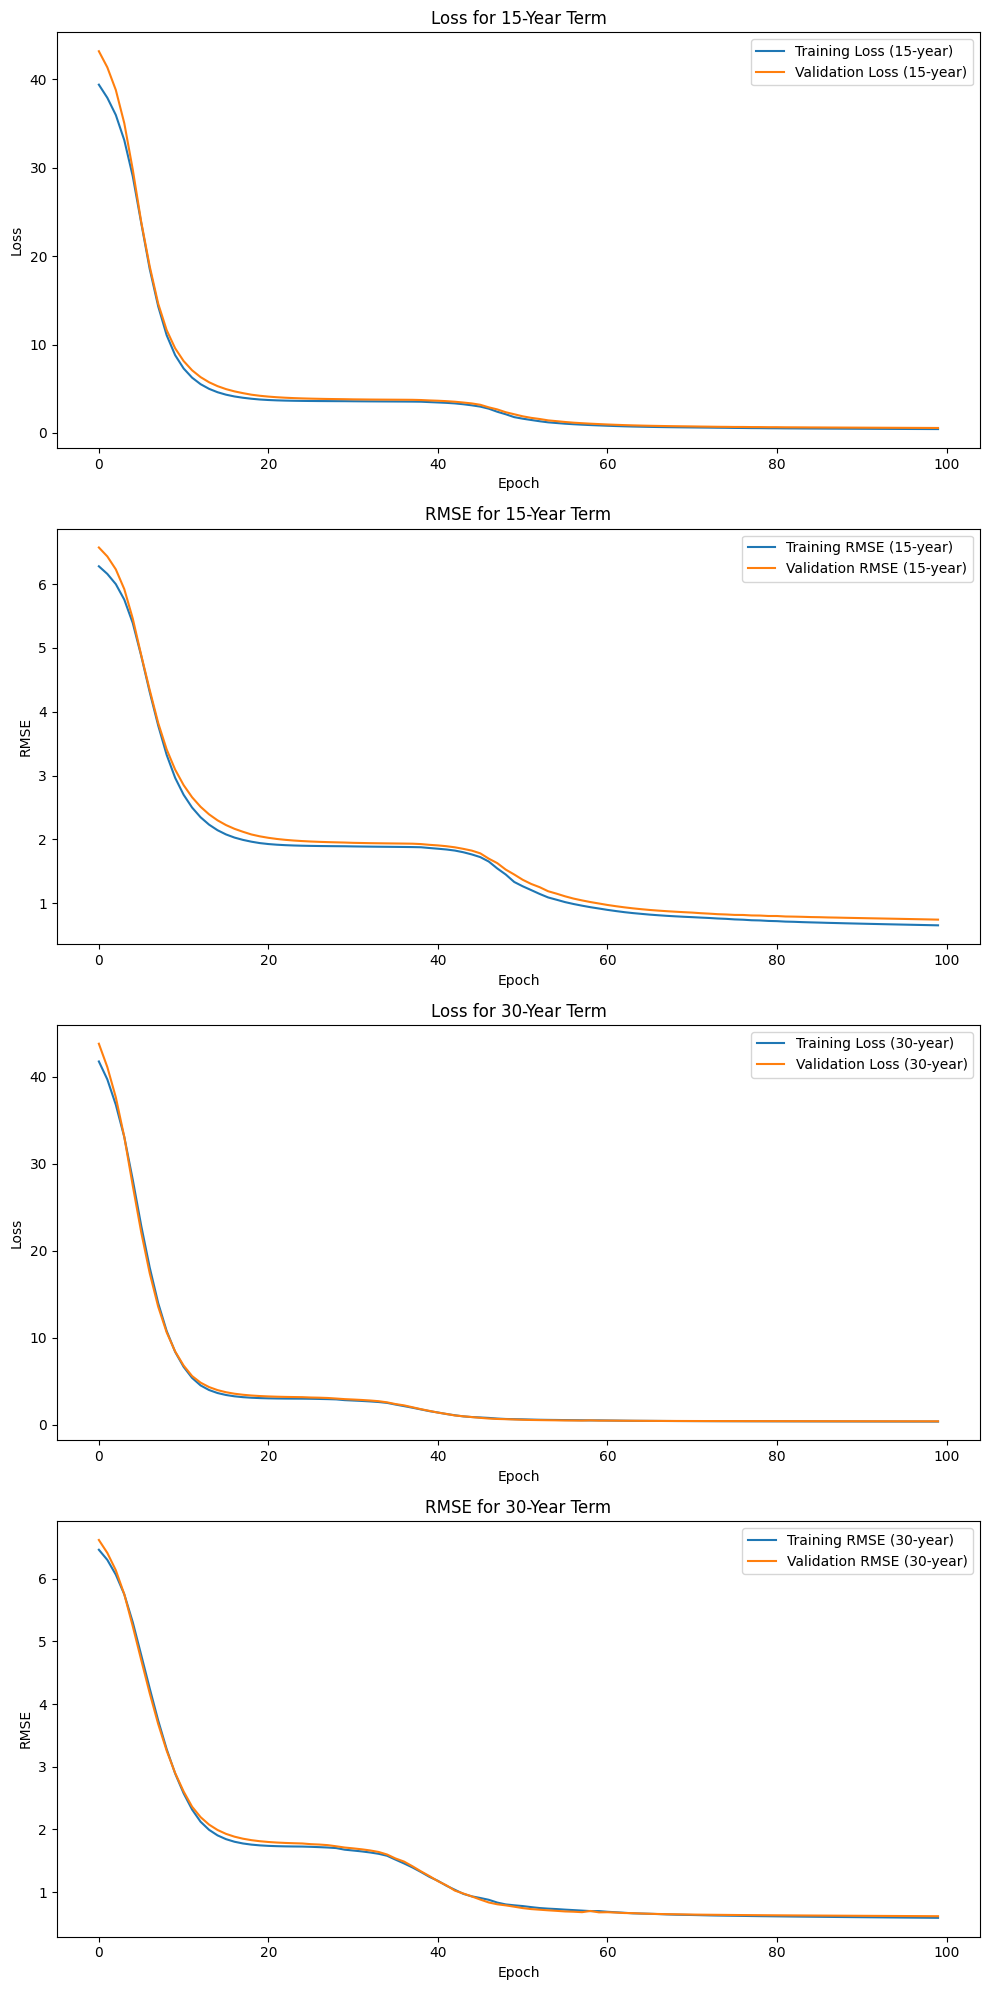

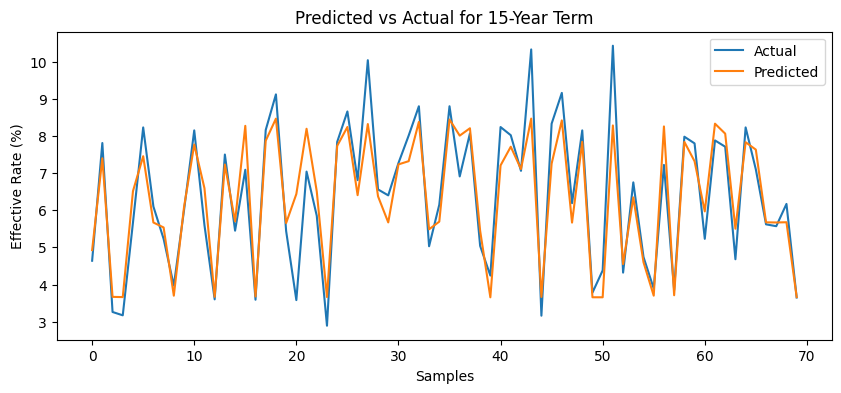

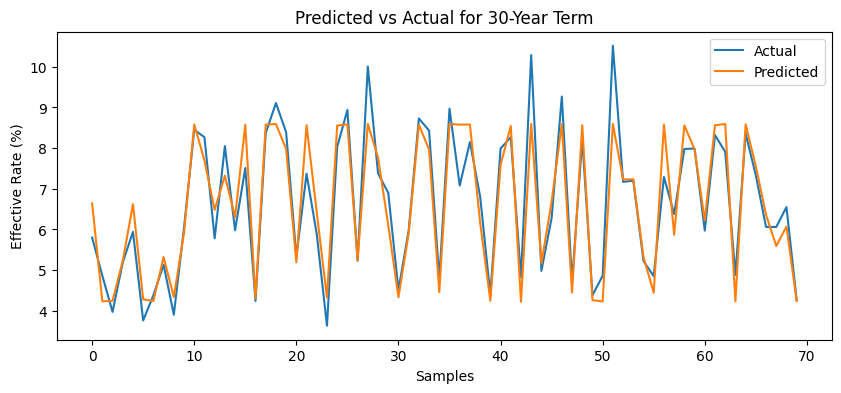

In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import math
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Load the dataset
def load_data(path):
    df = pd.read_csv(path)
    df = df.drop(index=0)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(inplace=True)  # Handling NaNs by removing; you might choose to fill them instead
    df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(Day=1))
    df.sort_values('Date', inplace=True)
    df.drop(['Year', 'Month'], axis=1, inplace=True)
    return df

# Define RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SimpleRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        return self.fc(out)

# Create sequences for modeling
def create_sequences(data, sequence_length):
    X = []
    y = []
    feature_data = data.drop(['Effective Rate (%)', 'Date'], axis=1)
    target_data = data['Effective Rate (%)']
    for i in range(len(data) - sequence_length):
        seq = feature_data.iloc[i:(i + sequence_length)].values
        label = target_data.iloc[i + sequence_length]
        X.append(seq)
        y.append(label)
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# Prepare data loaders
def prepare_data(X, y, batch_size=32, test_size=0.2):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

# Compute RMSE
def compute_rmse(predictions, targets):
    return math.sqrt(((predictions - targets) ** 2).mean())

def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, train_loss_list, val_loss_list, train_rmse_list, val_rmse_list):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_predictions, train_targets_list = [], []
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            train_predictions.extend(outputs.detach().squeeze().tolist())
            train_targets_list.extend(targets.tolist())

        train_loss /= len(train_loader.dataset)
        train_loss_list.append(train_loss)
        train_rmse = compute_rmse(np.array(train_predictions), np.array(train_targets_list))
        train_rmse_list.append(train_rmse)

        model.eval()
        val_loss = 0.0
        val_predictions, val_targets_list = [], []
        for val_inputs, val_targets in val_loader:
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs.squeeze(), val_targets).item() * val_inputs.size(0)
            val_predictions.extend(val_outputs.detach().squeeze().tolist())
            val_targets_list.extend(val_targets.tolist())

        val_loss /= len(val_loader.dataset)
        val_loss_list.append(val_loss)
        val_rmse = compute_rmse(np.array(val_predictions), np.array(val_targets_list))
        val_rmse_list.append(val_rmse)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
            print(f'Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}')

    return model

# Main execution
if __name__ == "__main__":
    dataset_path = 'Cleaned_FHFAInterestRates.csv'
    df = load_data(dataset_path)
    df_15 = df[df['Term to Maturity'] == 15].copy()
    df_30 = df[df['Term to Maturity'] == 30].copy()

    X_15, y_15 = create_sequences(df_15, 3)
    X_30, y_30 = create_sequences(df_30, 3)

    model_15 = SimpleRNN(7, 25, 2, 1)
    model_30 = SimpleRNN(7, 25, 2, 1)

    train_loader_15, val_loader_15 = prepare_data(X_15, y_15)
    train_loader_30, val_loader_30 = prepare_data(X_30, y_30)

    criterion = nn.MSELoss()
    optimizer_15 = optim.Adam(model_15.parameters(), lr=0.001)
    optimizer_30 = optim.Adam(model_30.parameters(), lr=0.001)

    train_loss_list_15 = []
    val_loss_list_15 = []
    train_rmse_list_15 = []
    val_rmse_list_15 = []

    train_loss_list_30 = []
    val_loss_list_30 = []
    train_rmse_list_30 = []
    val_rmse_list_30 = []

    trained_model_15 = train_model(model_15, train_loader_15, val_loader_15, optimizer_15, criterion, 100, train_loss_list_15, val_loss_list_15, train_rmse_list_15, val_rmse_list_15)
    trained_model_30 = train_model(model_30, train_loader_30, val_loader_30, optimizer_30, criterion, 100, train_loss_list_30, val_loss_list_30, train_rmse_list_30, val_rmse_list_30)

    # Plotting the results
    fig, axes = plt.subplots(4, 1, figsize=(10, 20))

    axes[0].plot(train_loss_list_15, label='Training Loss (15-year)')
    axes[0].plot(val_loss_list_15, label='Validation Loss (15-year)')
    axes[0].set_title('Loss for 15-Year Term')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(train_rmse_list_15, label='Training RMSE (15-year)')
    axes[1].plot(val_rmse_list_15, label='Validation RMSE (15-year)')
    axes[1].set_title('RMSE for 15-Year Term')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('RMSE')
    axes[1].legend()

    axes[2].plot(train_loss_list_30, label='Training Loss (30-year)')
    axes[2].plot(val_loss_list_30, label='Validation Loss (30-year)')
    axes[2].set_title('Loss for 30-Year Term')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')
    axes[2].legend()

    axes[3].plot(train_rmse_list_30, label='Training RMSE (30-year)')
    axes[3].plot(val_rmse_list_30, label='Validation RMSE (30-year)')
    axes[3].set_title('RMSE for 30-Year Term')
    axes[3].set_xlabel('Epoch')
    axes[3].set_ylabel('RMSE')
    axes[3].legend()

    plt.tight_layout()
    plt.show()

def plot_predictions(model, loader, title):
  model.eval()
  predictions, actuals = [], []
  with torch.no_grad():
      for inputs, targets in loader:
          outputs = model(inputs)
          predictions.extend(outputs.detach().squeeze().tolist())
          actuals.extend(targets.tolist())
  plt.figure(figsize=(10, 4))
  plt.plot(actuals, label='Actual')
  plt.plot(predictions, label='Predicted')
  plt.title(f'Predicted vs Actual for {title}')
  plt.xlabel('Samples')
  plt.ylabel('Effective Rate (%)')
  plt.legend()
  plt.show()

# Plot predicted vs actual for 15-year term
plot_predictions(trained_model_15, val_loader_15, '15-Year Term')

# Plot predicted vs actual for 30-year term
plot_predictions(trained_model_30, val_loader_30, '30-Year Term')

Number of layers:3

Epoch 10/100, Training Loss: 6.7710, Validation Loss: 7.3721
Train RMSE: 2.6021, Val RMSE: 2.7152
Epoch 20/100, Training Loss: 3.6640, Validation Loss: 3.9622
Train RMSE: 1.9142, Val RMSE: 1.9905
Epoch 30/100, Training Loss: 3.6348, Validation Loss: 3.8422
Train RMSE: 1.9065, Val RMSE: 1.9602
Epoch 40/100, Training Loss: 3.6270, Validation Loss: 3.8273
Train RMSE: 1.9045, Val RMSE: 1.9564
Epoch 50/100, Training Loss: 3.6037, Validation Loss: 3.8055
Train RMSE: 1.8983, Val RMSE: 1.9508
Epoch 60/100, Training Loss: 3.5251, Validation Loss: 3.7232
Train RMSE: 1.8775, Val RMSE: 1.9296
Epoch 70/100, Training Loss: 1.7663, Validation Loss: 1.7936
Train RMSE: 1.3290, Val RMSE: 1.3393
Epoch 80/100, Training Loss: 0.7987, Validation Loss: 0.8891
Train RMSE: 0.8937, Val RMSE: 0.9429
Epoch 90/100, Training Loss: 0.5697, Validation Loss: 0.5971
Train RMSE: 0.7548, Val RMSE: 0.7727
Epoch 100/100, Training Loss: 0.5153, Validation Loss: 0.5674
Train RMSE: 0.7178, Val RMSE: 0.7532
Epoch 10/100, Train

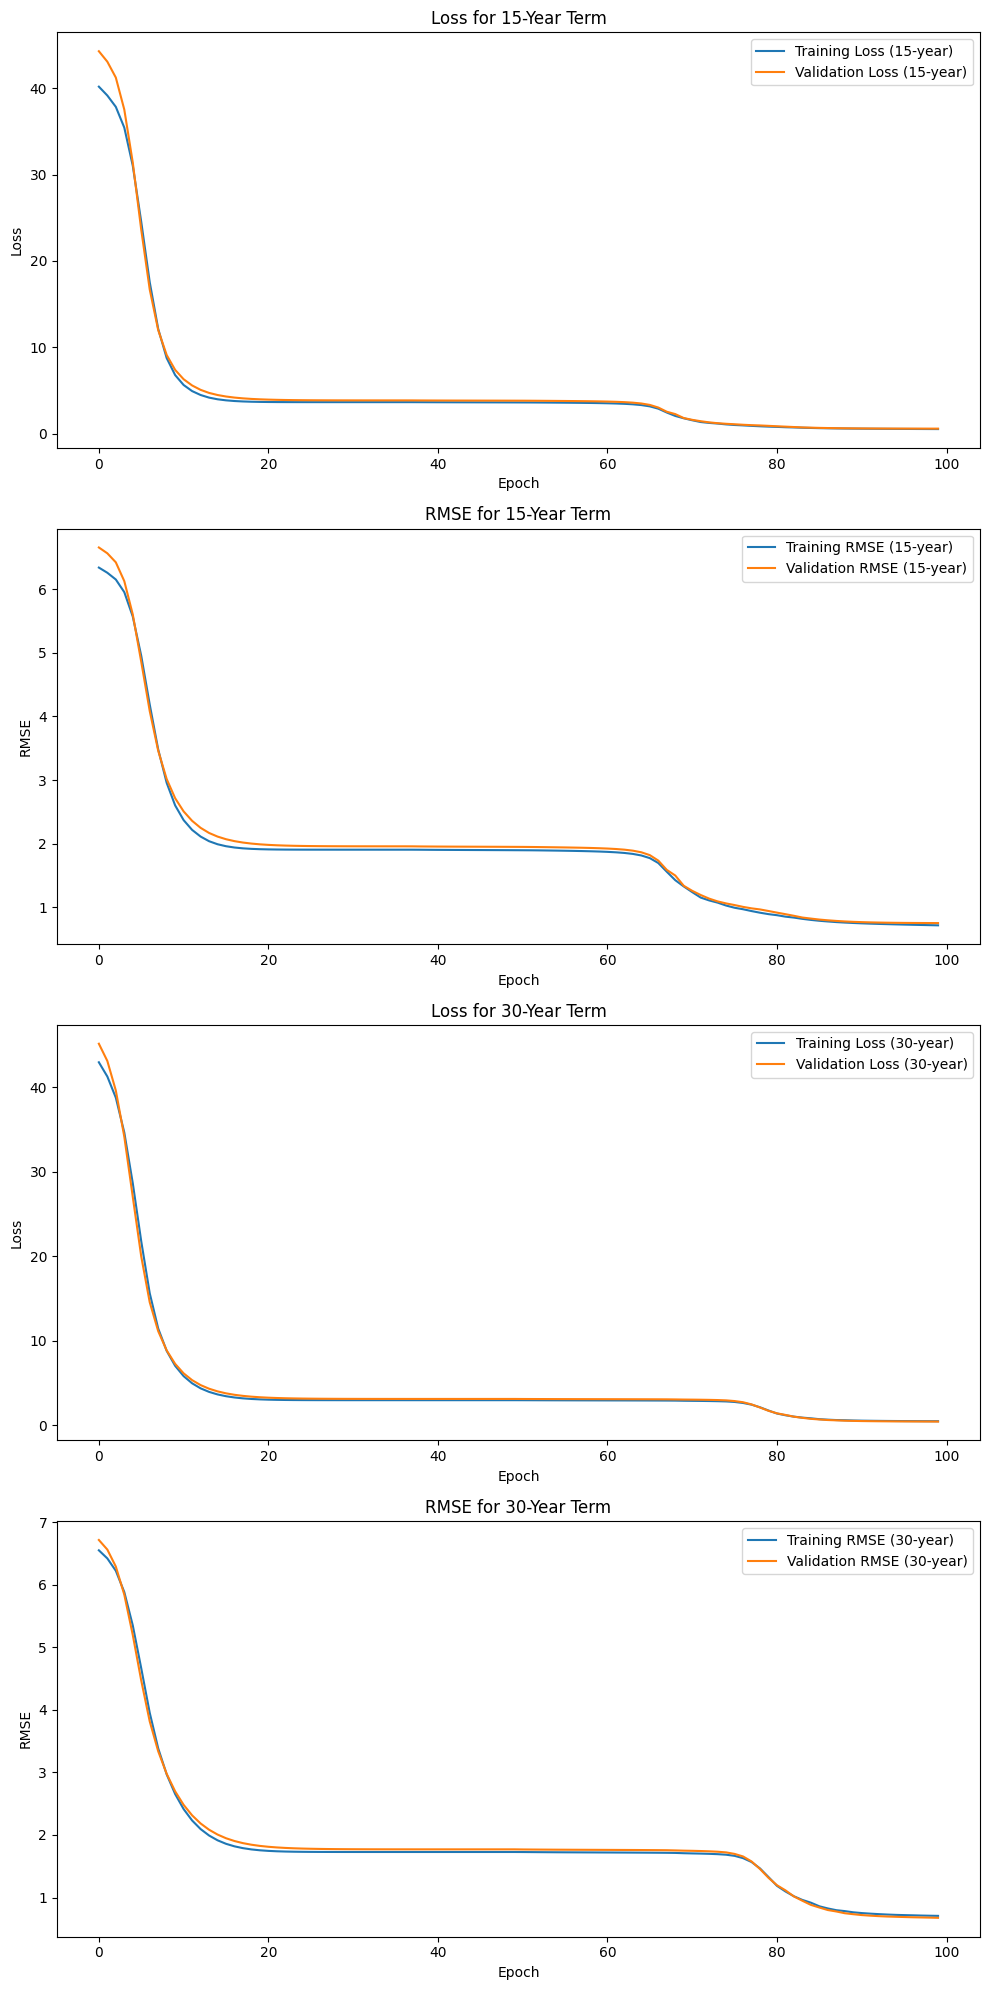

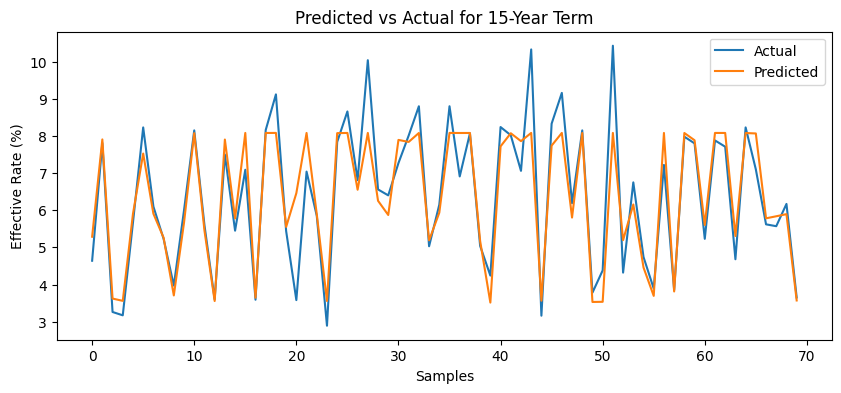

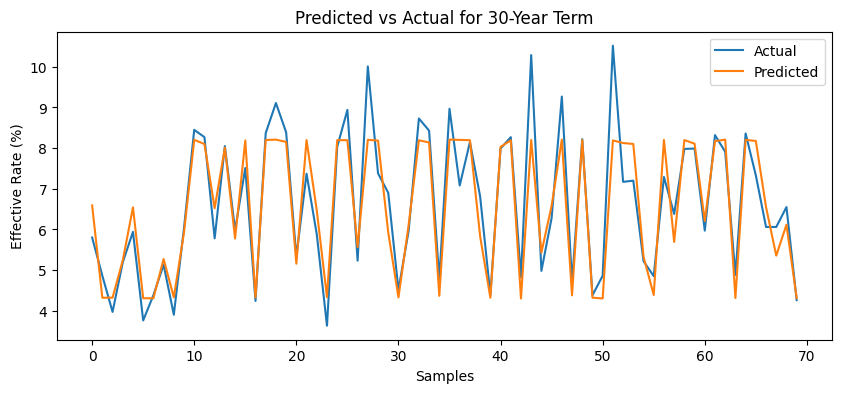

In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import math
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Load the dataset
def load_data(path):
    df = pd.read_csv(path)
    df = df.drop(index=0)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(inplace=True)  # Handling NaNs by removing; you might choose to fill them instead
    df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(Day=1))
    df.sort_values('Date', inplace=True)
    df.drop(['Year', 'Month'], axis=1, inplace=True)
    return df

# Define RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SimpleRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        return self.fc(out)

# Create sequences for modeling
def create_sequences(data, sequence_length):
    X = []
    y = []
    feature_data = data.drop(['Effective Rate (%)', 'Date'], axis=1)
    target_data = data['Effective Rate (%)']
    for i in range(len(data) - sequence_length):
        seq = feature_data.iloc[i:(i + sequence_length)].values
        label = target_data.iloc[i + sequence_length]
        X.append(seq)
        y.append(label)
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# Prepare data loaders
def prepare_data(X, y, batch_size=32, test_size=0.2):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

# Compute RMSE
def compute_rmse(predictions, targets):
    return math.sqrt(((predictions - targets) ** 2).mean())

def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, train_loss_list, val_loss_list, train_rmse_list, val_rmse_list):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_predictions, train_targets_list = [], []
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            train_predictions.extend(outputs.detach().squeeze().tolist())
            train_targets_list.extend(targets.tolist())

        train_loss /= len(train_loader.dataset)
        train_loss_list.append(train_loss)
        train_rmse = compute_rmse(np.array(train_predictions), np.array(train_targets_list))
        train_rmse_list.append(train_rmse)

        model.eval()
        val_loss = 0.0
        val_predictions, val_targets_list = [], []
        for val_inputs, val_targets in val_loader:
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs.squeeze(), val_targets).item() * val_inputs.size(0)
            val_predictions.extend(val_outputs.detach().squeeze().tolist())
            val_targets_list.extend(val_targets.tolist())

        val_loss /= len(val_loader.dataset)
        val_loss_list.append(val_loss)
        val_rmse = compute_rmse(np.array(val_predictions), np.array(val_targets_list))
        val_rmse_list.append(val_rmse)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
            print(f'Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}')

    return model

# Main execution
if __name__ == "__main__":
    dataset_path = 'Cleaned_FHFAInterestRates.csv'
    df = load_data(dataset_path)
    df_15 = df[df['Term to Maturity'] == 15].copy()
    df_30 = df[df['Term to Maturity'] == 30].copy()

    X_15, y_15 = create_sequences(df_15, 3)
    X_30, y_30 = create_sequences(df_30, 3)

    model_15 = SimpleRNN(7, 25, 3, 1)
    model_30 = SimpleRNN(7, 25, 3, 1)

    train_loader_15, val_loader_15 = prepare_data(X_15, y_15)
    train_loader_30, val_loader_30 = prepare_data(X_30, y_30)

    criterion = nn.MSELoss()
    optimizer_15 = optim.Adam(model_15.parameters(), lr=0.001)
    optimizer_30 = optim.Adam(model_30.parameters(), lr=0.001)

    train_loss_list_15 = []
    val_loss_list_15 = []
    train_rmse_list_15 = []
    val_rmse_list_15 = []

    train_loss_list_30 = []
    val_loss_list_30 = []
    train_rmse_list_30 = []
    val_rmse_list_30 = []

    trained_model_15 = train_model(model_15, train_loader_15, val_loader_15, optimizer_15, criterion, 100, train_loss_list_15, val_loss_list_15, train_rmse_list_15, val_rmse_list_15)
    trained_model_30 = train_model(model_30, train_loader_30, val_loader_30, optimizer_30, criterion, 100, train_loss_list_30, val_loss_list_30, train_rmse_list_30, val_rmse_list_30)

    # Plotting the results
    fig, axes = plt.subplots(4, 1, figsize=(10, 20))

    axes[0].plot(train_loss_list_15, label='Training Loss (15-year)')
    axes[0].plot(val_loss_list_15, label='Validation Loss (15-year)')
    axes[0].set_title('Loss for 15-Year Term')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(train_rmse_list_15, label='Training RMSE (15-year)')
    axes[1].plot(val_rmse_list_15, label='Validation RMSE (15-year)')
    axes[1].set_title('RMSE for 15-Year Term')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('RMSE')
    axes[1].legend()

    axes[2].plot(train_loss_list_30, label='Training Loss (30-year)')
    axes[2].plot(val_loss_list_30, label='Validation Loss (30-year)')
    axes[2].set_title('Loss for 30-Year Term')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')
    axes[2].legend()

    axes[3].plot(train_rmse_list_30, label='Training RMSE (30-year)')
    axes[3].plot(val_rmse_list_30, label='Validation RMSE (30-year)')
    axes[3].set_title('RMSE for 30-Year Term')
    axes[3].set_xlabel('Epoch')
    axes[3].set_ylabel('RMSE')
    axes[3].legend()

    plt.tight_layout()
    plt.show()

def plot_predictions(model, loader, title):
  model.eval()
  predictions, actuals = [], []
  with torch.no_grad():
      for inputs, targets in loader:
          outputs = model(inputs)
          predictions.extend(outputs.detach().squeeze().tolist())
          actuals.extend(targets.tolist())
  plt.figure(figsize=(10, 4))
  plt.plot(actuals, label='Actual')
  plt.plot(predictions, label='Predicted')
  plt.title(f'Predicted vs Actual for {title}')
  plt.xlabel('Samples')
  plt.ylabel('Effective Rate (%)')
  plt.legend()
  plt.show()

# Plot predicted vs actual for 15-year term
plot_predictions(trained_model_15, val_loader_15, '15-Year Term')

# Plot predicted vs actual for 30-year term
plot_predictions(trained_model_30, val_loader_30, '30-Year Term')

Epoch 10/50, Training Loss: 2.0519, Validation Loss: 1.9677
Train RMSE: 1.4324, Val RMSE: 1.4027
Epoch 20/50, Training Loss: 1.1089, Validation Loss: 1.1367
Train RMSE: 1.0530, Val RMSE: 1.0662
Epoch 30/50, Training Loss: 0.6708, Validation Loss: 0.7942
Train RMSE: 0.8190, Val RMSE: 0.8912
Epoch 40/50, Training Loss: 0.4198, Validation Loss: 0.5633
Train RMSE: 0.6479, Val RMSE: 0.7505
Epoch 50/50, Training Loss: 0.3078, Validation Loss: 0.4782
Train RMSE: 0.5548, Val RMSE: 0.6915
Epoch 10/50, Training Loss: 2.7447, Validation Loss: 2.8259
Train RMSE: 1.6567, Val RMSE: 1.6810
Epoch 20/50, Training Loss: 1.3983, Validation Loss: 1.3260
Train RMSE: 1.1825, Val RMSE: 1.1515
Epoch 30/50, Training Loss: 0.8051, Validation Loss: 0.7118
Train RMSE: 0.8973, Val RMSE: 0.8437
Epoch 40/50, Training Loss: 0.6050, Validation Loss: 0.5271
Train RMSE: 0.7778, Val RMSE: 0.7260
Epoch 50/50, Training Loss: 0.5034, Validation Loss: 0.4364
Train RMSE: 0.7095, Val RMSE: 0.6606


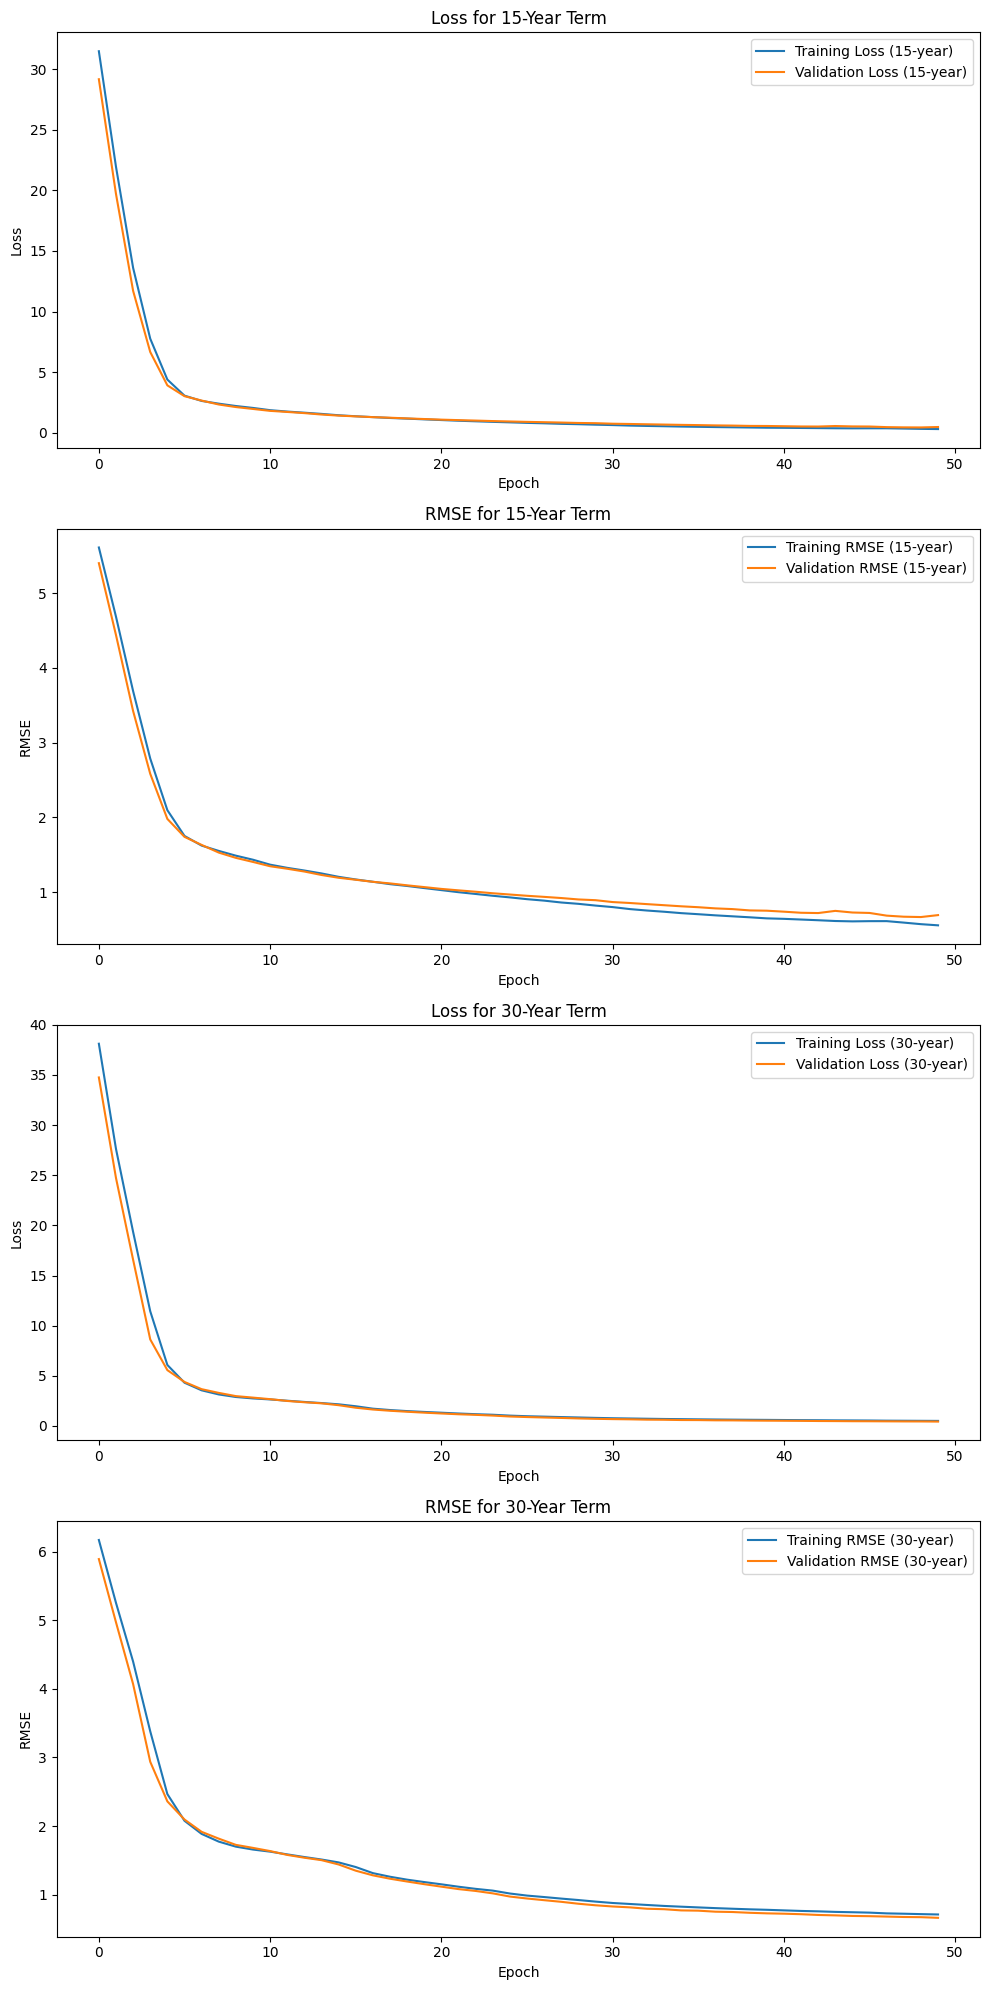

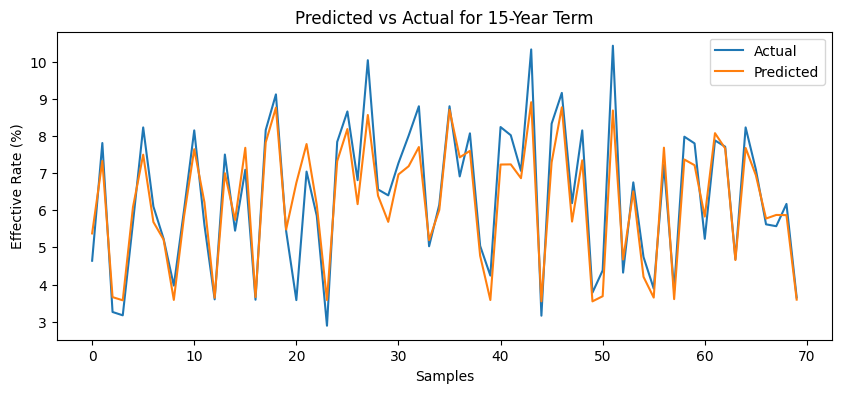

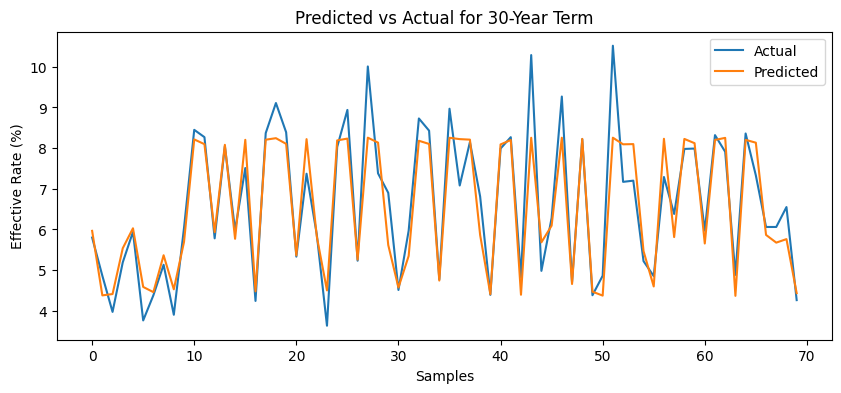

In [17]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import math
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Load the dataset
def load_data(path):
    df = pd.read_csv(path)
    df = df.drop(index=0)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(inplace=True)  # Handling NaNs by removing; you might choose to fill them instead
    df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(Day=1))
    df.sort_values('Date', inplace=True)
    df.drop(['Year', 'Month'], axis=1, inplace=True)
    return df

# Define RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SimpleRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        return self.fc(out)

# Create sequences for modeling
def create_sequences(data, sequence_length):
    X = []
    y = []
    feature_data = data.drop(['Effective Rate (%)', 'Date'], axis=1)
    target_data = data['Effective Rate (%)']
    for i in range(len(data) - sequence_length):
        seq = feature_data.iloc[i:(i + sequence_length)].values
        label = target_data.iloc[i + sequence_length]
        X.append(seq)
        y.append(label)
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# Prepare data loaders
def prepare_data(X, y, batch_size=32, test_size=0.2):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

# Compute RMSE
def compute_rmse(predictions, targets):
    return math.sqrt(((predictions - targets) ** 2).mean())

def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, train_loss_list, val_loss_list, train_rmse_list, val_rmse_list):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_predictions, train_targets_list = [], []
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            train_predictions.extend(outputs.detach().squeeze().tolist())
            train_targets_list.extend(targets.tolist())

        train_loss /= len(train_loader.dataset)
        train_loss_list.append(train_loss)
        train_rmse = compute_rmse(np.array(train_predictions), np.array(train_targets_list))
        train_rmse_list.append(train_rmse)

        model.eval()
        val_loss = 0.0
        val_predictions, val_targets_list = [], []
        for val_inputs, val_targets in val_loader:
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs.squeeze(), val_targets).item() * val_inputs.size(0)
            val_predictions.extend(val_outputs.detach().squeeze().tolist())
            val_targets_list.extend(val_targets.tolist())

        val_loss /= len(val_loader.dataset)
        val_loss_list.append(val_loss)
        val_rmse = compute_rmse(np.array(val_predictions), np.array(val_targets_list))
        val_rmse_list.append(val_rmse)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
            print(f'Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}')

    return model

# Main execution
if __name__ == "__main__":
    dataset_path = 'Cleaned_FHFAInterestRates.csv'
    df = load_data(dataset_path)
    df_15 = df[df['Term to Maturity'] == 15].copy()
    df_30 = df[df['Term to Maturity'] == 30].copy()

    X_15, y_15 = create_sequences(df_15, 3)
    X_30, y_30 = create_sequences(df_30, 3)

    model_15 = SimpleRNN(7, 100, 1, 1)
    model_30 = SimpleRNN(7, 100, 1, 1)

    train_loader_15, val_loader_15 = prepare_data(X_15, y_15)
    train_loader_30, val_loader_30 = prepare_data(X_30, y_30)

    criterion = nn.MSELoss()
    optimizer_15 = optim.Adam(model_15.parameters(), lr=0.001)
    optimizer_30 = optim.Adam(model_30.parameters(), lr=0.001)

    train_loss_list_15 = []
    val_loss_list_15 = []
    train_rmse_list_15 = []
    val_rmse_list_15 = []

    train_loss_list_30 = []
    val_loss_list_30 = []
    train_rmse_list_30 = []
    val_rmse_list_30 = []

    trained_model_15 = train_model(model_15, train_loader_15, val_loader_15, optimizer_15, criterion, 50, train_loss_list_15, val_loss_list_15, train_rmse_list_15, val_rmse_list_15)
    trained_model_30 = train_model(model_30, train_loader_30, val_loader_30, optimizer_30, criterion, 50, train_loss_list_30, val_loss_list_30, train_rmse_list_30, val_rmse_list_30)

    # Plotting the results
    fig, axes = plt.subplots(4, 1, figsize=(10, 20))

    axes[0].plot(train_loss_list_15, label='Training Loss (15-year)')
    axes[0].plot(val_loss_list_15, label='Validation Loss (15-year)')
    axes[0].set_title('Loss for 15-Year Term')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(train_rmse_list_15, label='Training RMSE (15-year)')
    axes[1].plot(val_rmse_list_15, label='Validation RMSE (15-year)')
    axes[1].set_title('RMSE for 15-Year Term')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('RMSE')
    axes[1].legend()

    axes[2].plot(train_loss_list_30, label='Training Loss (30-year)')
    axes[2].plot(val_loss_list_30, label='Validation Loss (30-year)')
    axes[2].set_title('Loss for 30-Year Term')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')
    axes[2].legend()

    axes[3].plot(train_rmse_list_30, label='Training RMSE (30-year)')
    axes[3].plot(val_rmse_list_30, label='Validation RMSE (30-year)')
    axes[3].set_title('RMSE for 30-Year Term')
    axes[3].set_xlabel('Epoch')
    axes[3].set_ylabel('RMSE')
    axes[3].legend()

    plt.tight_layout()
    plt.show()

def plot_predictions(model, loader, title):
  model.eval()
  predictions, actuals = [], []
  with torch.no_grad():
      for inputs, targets in loader:
          outputs = model(inputs)
          predictions.extend(outputs.detach().squeeze().tolist())
          actuals.extend(targets.tolist())
  plt.figure(figsize=(10, 4))
  plt.plot(actuals, label='Actual')
  plt.plot(predictions, label='Predicted')
  plt.title(f'Predicted vs Actual for {title}')
  plt.xlabel('Samples')
  plt.ylabel('Effective Rate (%)')
  plt.legend()
  plt.show()

# Plot predicted vs actual for 15-year term
plot_predictions(trained_model_15, val_loader_15, '15-Year Term')

# Plot predicted vs actual for 30-year term
plot_predictions(trained_model_30, val_loader_30, '30-Year Term')